# Miso Analysis

Annabelle Kanchirathingal

This project is a comprehensive analysis of the MISO hourly load data from 2018-2024

In [ ]:
# Connecting to dataset
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
import os
os.chdir("/content/gdrive/My Drive/Work/MISO_Analysis")

Mounted at /content/gdrive


# Imports


In [ ]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import datetime
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')

# Data Preprocessing

In [ ]:
# Loading Dataset of MISO hourly load data from 01/01/2018 - 12/31/2024
df = pd.read_csv("MISO_2018-2024.csv")
df.head()

,DATE,ForecastedLoad,ClearedLoad,ActualLoad
0,1/1/2018 12:00:00 AM,84605,88277,89034.0
1,1/1/2018 1:00:00 AM,85731,86919,87587.0
2,1/1/2018 2:00:00 AM,84271,86044,86675.0
3,1/1/2018 3:00:00 AM,83256,85295,86087.0
4,1/1/2018 4:00:00 AM,82214,85022,86134.0


*Here we can see that the DATE attribute has the date backwards, we will need to fix that during data preprocessing*

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56102 entries, 0 to 56101
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DATE            56102 non-null  object 
 1   ForecastedLoad  56102 non-null  int64  
 2   ClearedLoad     56102 non-null  int64  
 3   ActualLoad      55568 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 1.7+ MB


*The DATE attribute is currrently an object & the values for all other columns & the ActualLoad column do not match up*

In [ ]:
# Handling the DATE attribute
df["DATE"] = pd.to_datetime(df["DATE"])

# Setting DATE as Index
df.set_index("DATE", inplace=True)

In [ ]:
# Time based interpolation for all columns, mainly focusing on ActualLoad
# Doing this for ForecastedLoad & ClearedLoad is not necessary, because there are no missing values to interpolate
for col in ['ActualLoad', 'ForecastedLoad', 'ClearedLoad']:
    df[col] = df[col].interpolate(method="time")

In [ ]:
df.head()

,ForecastedLoad,ClearedLoad,ActualLoad
DATE,,,
2018-01-01 00:00:00,84605,88277,89034.0
2018-01-01 01:00:00,85731,86919,87587.0
2018-01-01 02:00:00,84271,86044,86675.0
2018-01-01 03:00:00,83256,85295,86087.0
2018-01-01 04:00:00,82214,85022,86134.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 56102 entries, 2018-01-01 00:00:00 to 2024-12-31 23:00:00
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ForecastedLoad  56102 non-null  int64  
 1   ClearedLoad     56102 non-null  int64  
 2   ActualLoad      56102 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 1.7 MB


*We can see that the values for ActualLoad now matches up to ForecadtedLoad & ClearedLoad*

In [ ]:
# Statistics of each load type
print("Basic statistics for each load:")
print(df[['ActualLoad', 'ForecastedLoad', 'ClearedLoad']].describe())

Basic statistics for each load:
          ActualLoad  ForecastedLoad    ClearedLoad
count   56102.000000    56102.000000   56102.000000
mean    76035.917313    76193.256354   75383.670511
std     11861.833759    11708.250823   12543.591656
min     19379.000000    50538.000000   48332.000000
25%     67677.000000    68034.250000   66497.000000
50%     74161.000000    74295.000000   73475.000000
75%     82273.000000    82276.750000   82012.750000
max    124675.000000   127195.000000  124889.000000


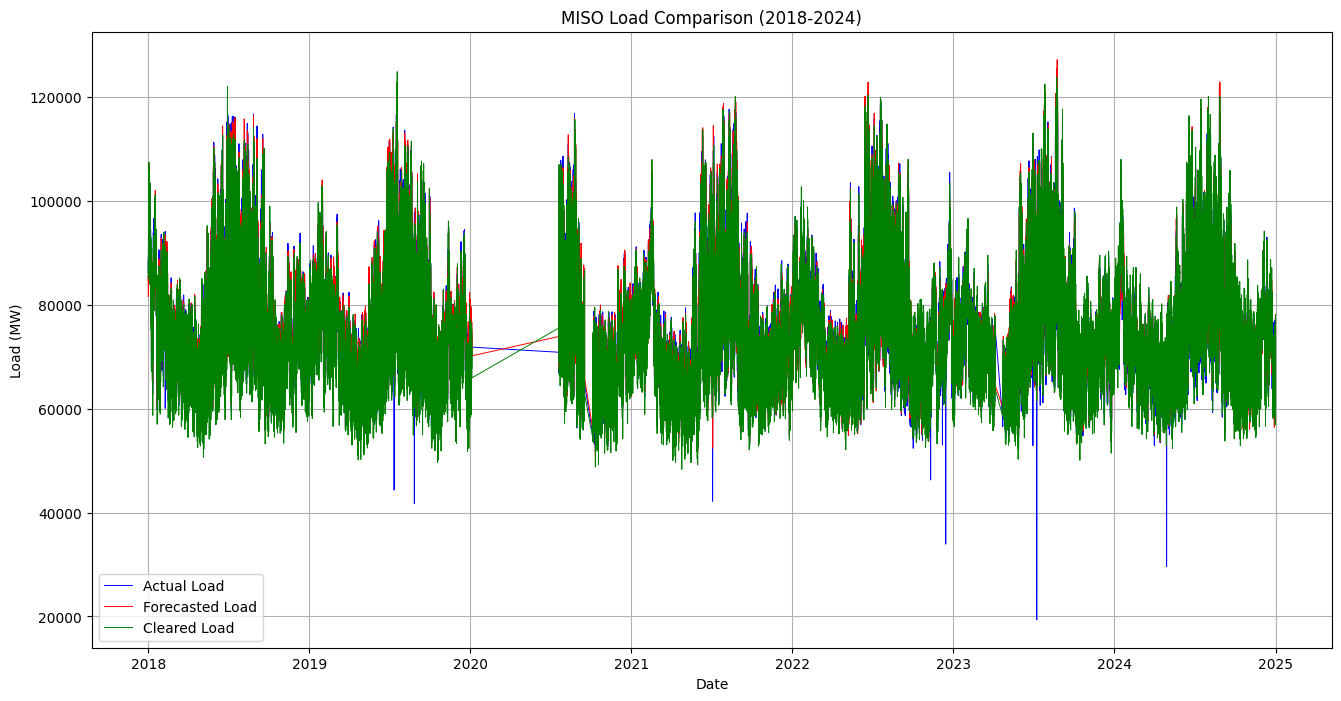

In [ ]:
# Visualizing all load over time
plt.figure(figsize=(16, 8))
plt.plot(df.index, df["ActualLoad"], label="Actual Load", color="blue", linewidth=0.7)
plt.plot(df.index, df["ForecastedLoad"], label="Forecasted Load", color="red", linewidth=0.7)
plt.plot(df.index, df["ClearedLoad"], label="Cleared Load", color="green", linewidth=0.7)
plt.xlabel("Date")
plt.ylabel("Load (MW)")
plt.title("MISO Load Comparison (2018-2024)")
plt.legend()
plt.grid()
plt.show()

# Error Metrics

In [ ]:
# Calculate forecasting error metrics
df['ForecastError'] = df['ActualLoad'] - df['ForecastedLoad']
df['ForecastErrorPercent'] = (df['ForecastError'] / df['ActualLoad']) * 100

# Calculating clearing error metrics
df['ClearingError'] = df['ActualLoad'] - df['ClearedLoad']
df['ClearingErrorPercent'] = (df['ClearingError'] / df['ActualLoad']) * 100

In [ ]:
# Displaying Forecasting error metrics
print("\nForecasting Error Metrics: ")
print(f"Mean Absolute Error: {df['ForecastError'].abs().mean():.2f} MW")
print(f"Mean Percentage Error: {df['ForecastErrorPercent'].mean():.2f}%")
print(f"Mean Absolute Percentage Error: {df['ForecastErrorPercent'].abs().mean():.2f}%")

# Displaying Clearning error metrics
print("\nClearing Error Metrics:")
print(f"Mean Absolute Error: {df['ClearingError'].abs().mean():.2f} MW")
print(f"Mean Percentage Error: {df['ClearingErrorPercent'].mean():.2f}%")
print(f"Mean Absolute Percentage Error: {df['ClearingErrorPercent'].abs().mean():.2f}%")


Forecasting Error Metrics: 
Mean Absolute Error: 1476.56 MW
Mean Percentage Error: -0.28%
Mean Absolute Percentage Error: 1.96%

Clearing Error Metrics:
Mean Absolute Error: 1819.54 MW
Mean Percentage Error: 0.97%
Mean Absolute Percentage Error: 2.44%


*The Forecasting Error metrics show that the forecasting load overestimates the demand slightly with an average error of 1476.56 MW. The accuracy of the forecasting error is quite good at 1.96%*

*The Clearing error metrics show that the clearing load tends to underestimate the demand. The accuracy for the clearing error is slightly higher at 2.44%, indicating there is more room for improvement in clearing predictions compared to forecasting*

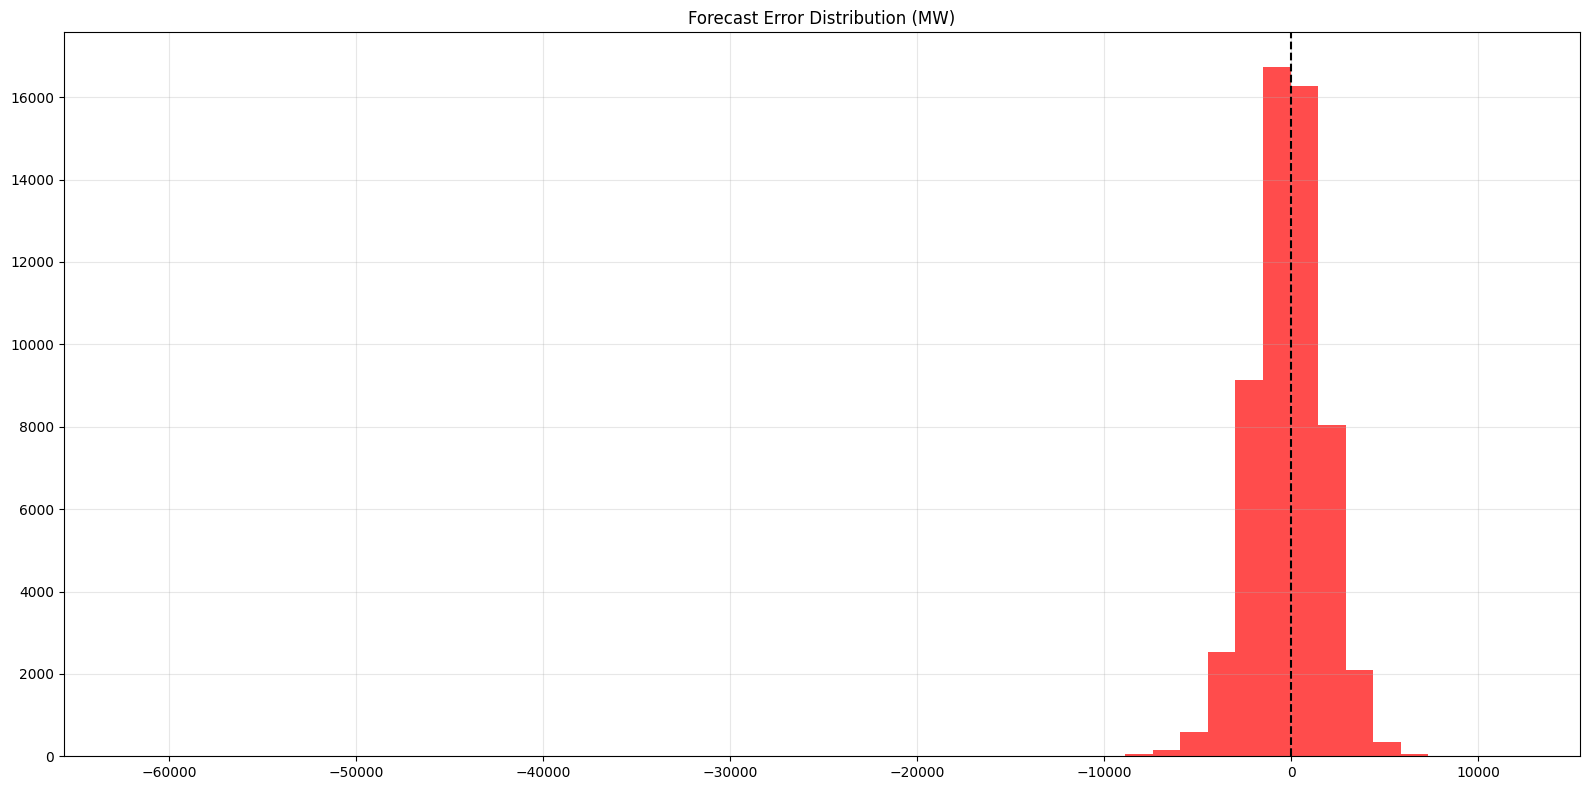

In [ ]:
# Ploting the Forecasting error distribution in MW
plt.figure(figsize=(16, 8))
plt.hist(df['ForecastError'].dropna(), bins=50, color='red', alpha=0.7)
plt.title('Forecast Error Distribution (MW)')
plt.axvline(x=0, color='black', linestyle='--')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

*The bell shaped distribution of the forecasting error indicate it is reliable*

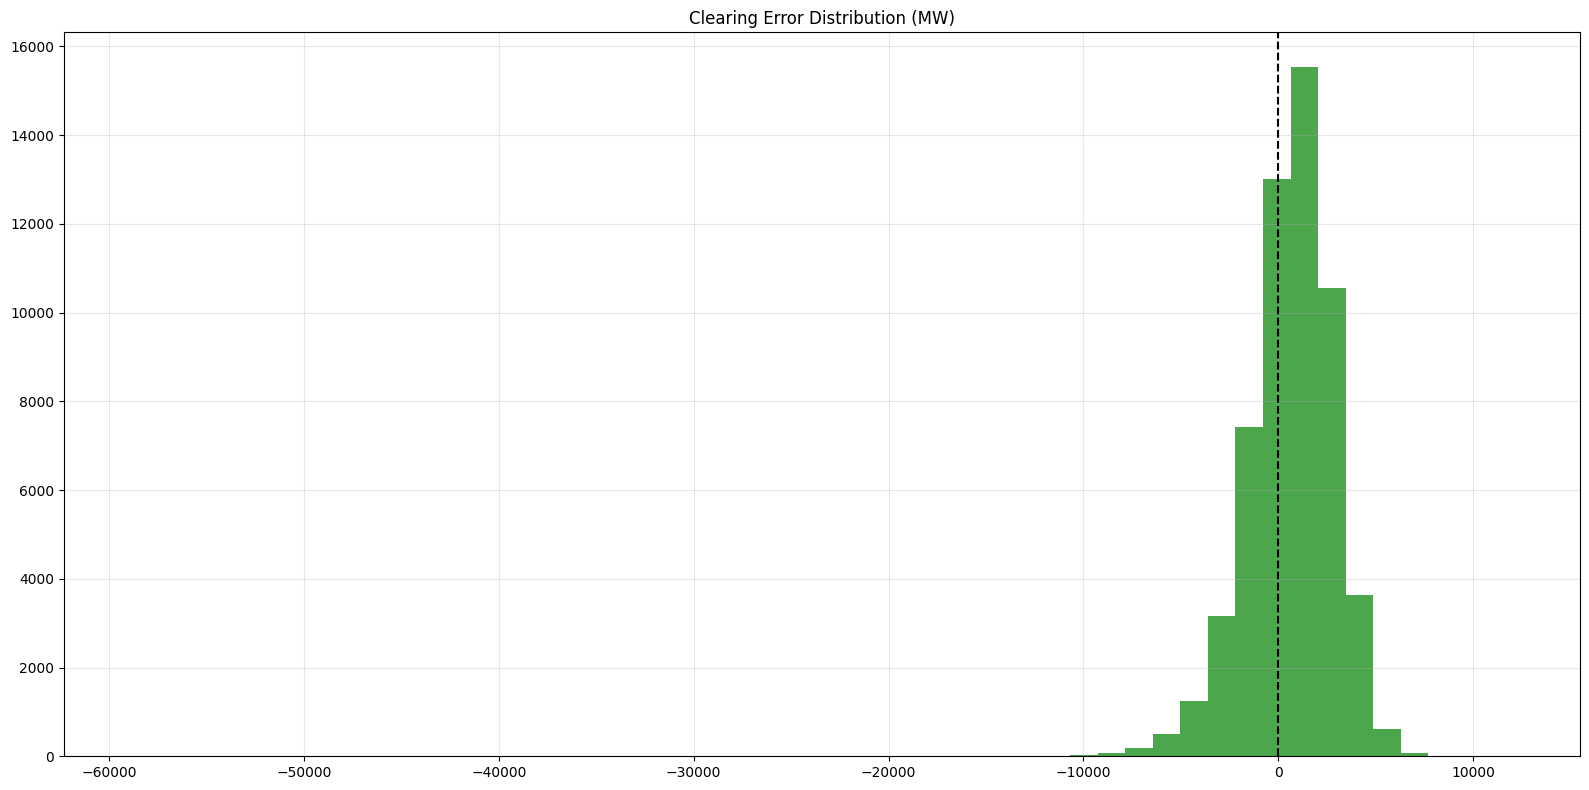

In [ ]:
# Plotting Clearing Error Distribution in MW
plt.figure(figsize=(16, 8))
plt.hist(df['ClearingError'].dropna(), bins=50, color='green', alpha=0.7)
plt.title('Clearing Error Distribution (MW)')
plt.axvline(x=0, color='black', linestyle='--')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

*the bell shaped distribution of the clearing error indicates it is reliable*

# Visualization for the first month of 2018

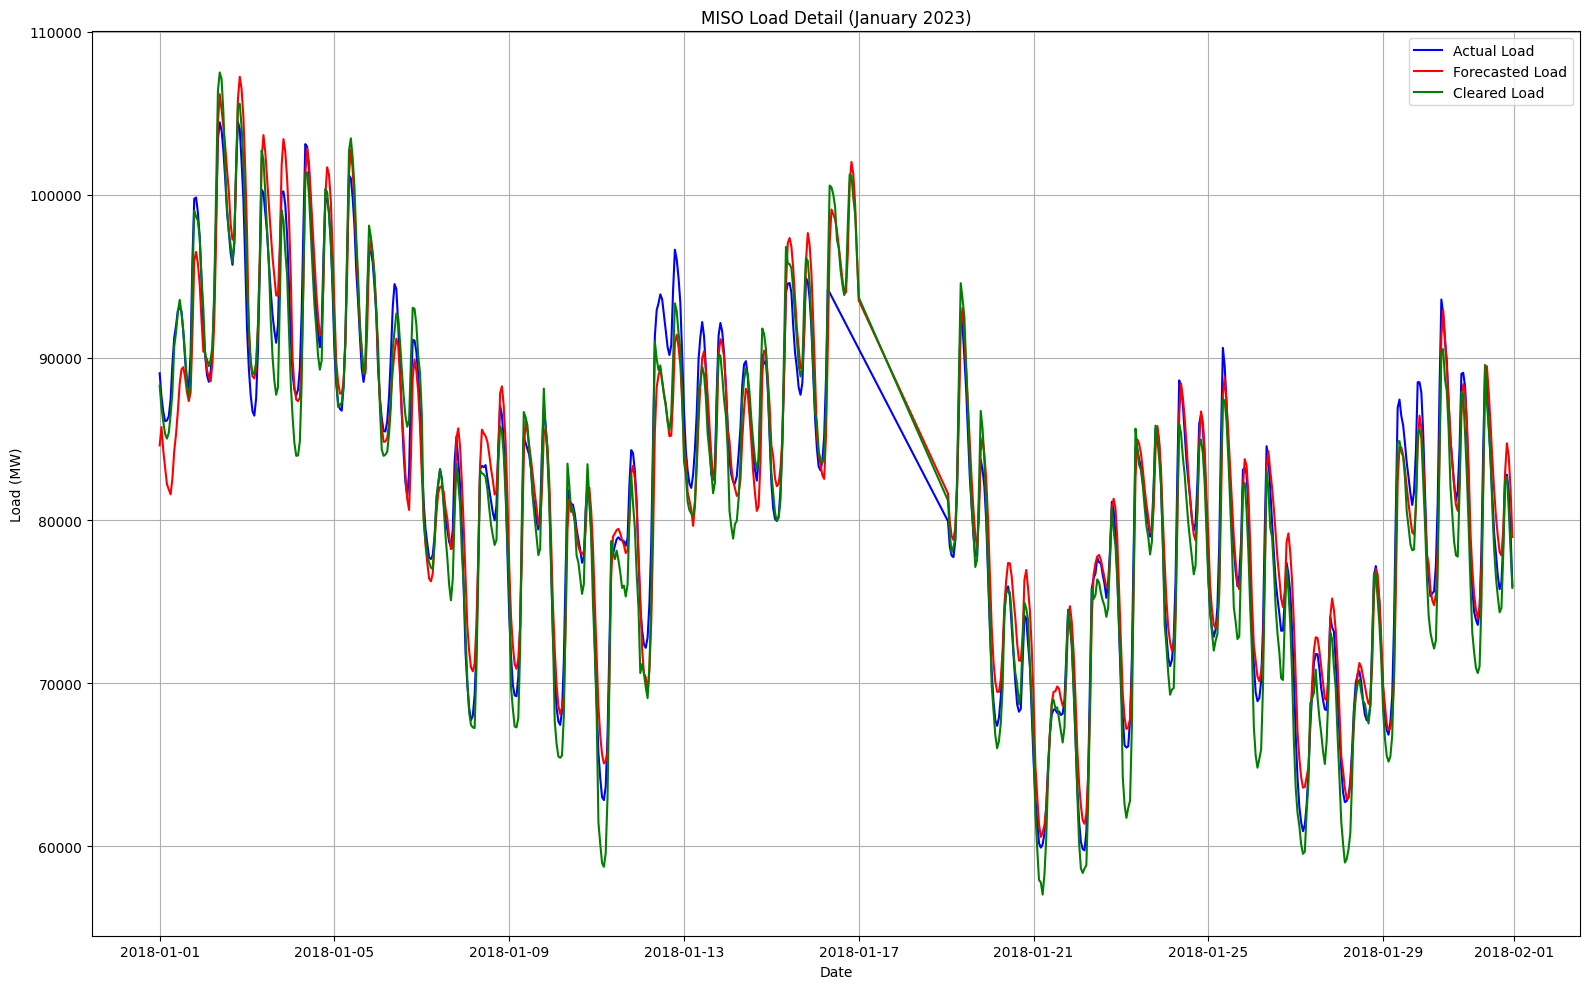

In [ ]:
# Plotting first month of 2018
recent_month = df.loc['2018-01-01':'2018-01-31']

plt.figure(figsize=(16, 10))
plt.plot(recent_month.index, recent_month["ActualLoad"], label="Actual Load", color="blue")
plt.plot(recent_month.index, recent_month["ForecastedLoad"], label="Forecasted Load", color="red")
plt.plot(recent_month.index, recent_month["ClearedLoad"], label="Cleared Load", color="green")
plt.xlabel("Date")
plt.ylabel("Load (MW)")
plt.title("MISO Load Detail (January 2023)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

*The jumps in the data from Jan 17th - Jan 19th is from the time interpolation*

*The beginning of the month shows high consumption which is indicative of colder weather. By the end of the month energy consumption slows down to a normal range*

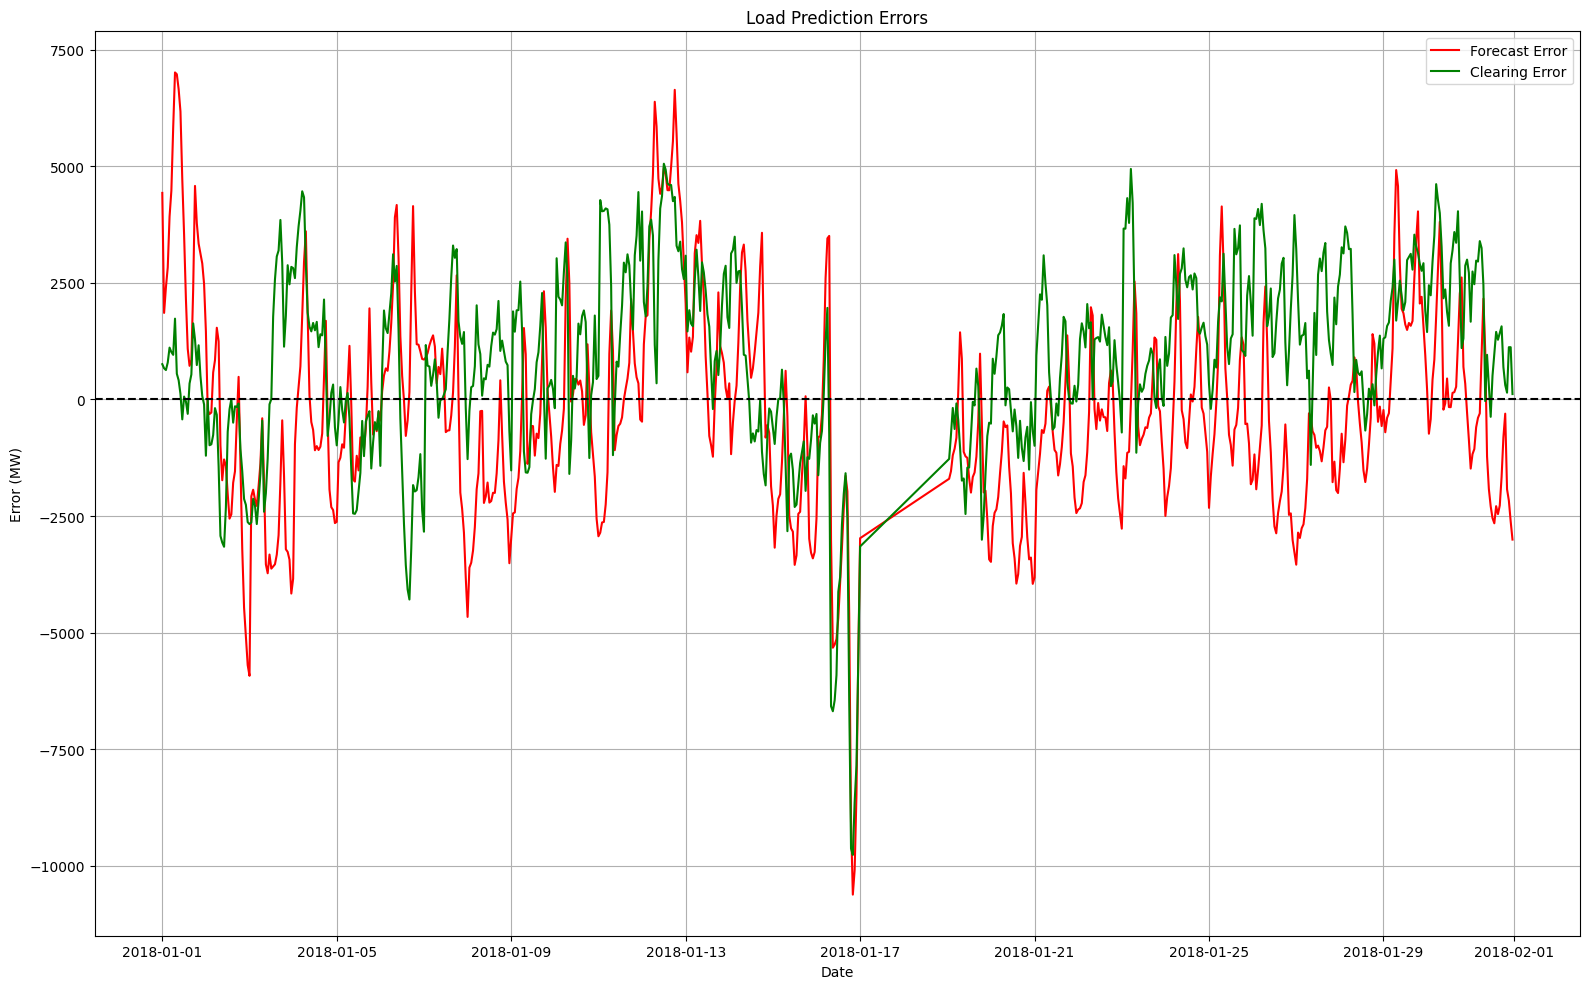

In [ ]:
#Plotting Load Prediction Errors for first month of 2018
recent_month = df.loc['2018-01-01':'2018-01-31']

plt.figure(figsize=(16, 10))
plt.plot(recent_month.index, recent_month["ForecastError"], label="Forecast Error", color="red")
plt.plot(recent_month.index, recent_month["ClearingError"], label="Clearing Error", color="green")
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel("Date")
plt.ylabel("Error (MW)")
plt.title("Load Prediction Errors")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

*The forecasting error seems to have more descrepancies throughout the month than the clearing error; the differences between the two indicate there may be some unusual conditions taking place during the month*

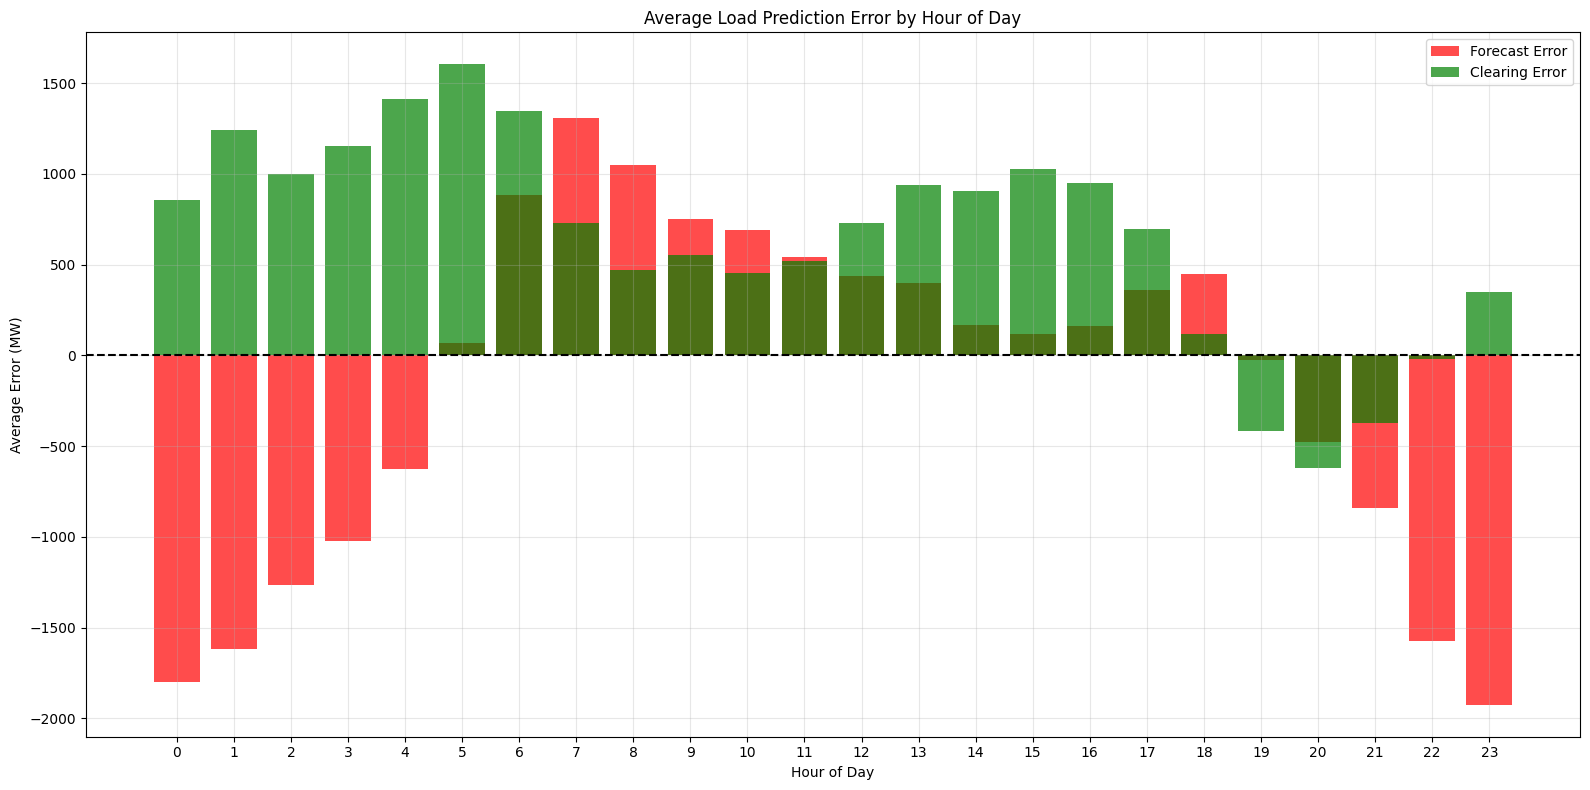

In [ ]:
# Analyze error patterns by hour of day
df['Hour'] = df.index.hour
hourly_errors = df.groupby('Hour')[['ForecastError', 'ForecastErrorPercent', 'ClearingError', 'ClearingErrorPercent']].mean()

plt.figure(figsize=(16, 8))

plt.bar(hourly_errors.index, hourly_errors['ForecastError'], color='red', alpha=0.7, label='Forecast Error')
plt.bar(hourly_errors.index, hourly_errors['ClearingError'], color='green', alpha=0.7, label='Clearing Error')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Hour of Day')
plt.ylabel('Average Error (MW)')
plt.title('Average Load Prediction Error by Hour of Day')
plt.xticks(range(0, 24))
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


*During the first four hours and last three hours of the day there is a visible difference between the mean forecasting error and the mean clearing error.*

*The forecasting error suggests the model is over-predicting demand during these hours. The clearing error suggests the system is underestimating the load during these hours. This misalignment can lead to overproduction & unnecessary costs in ensuring supply matches actual demand*

# Model Processing

In [ ]:
# Resampling to daily for ARIMA analysis
daily_actual = df["ActualLoad"].resample('D').mean()
daily_forecast = df["ForecastedLoad"].resample('D').mean()
daily_cleared = df["ClearedLoad"].resample('D').mean()

In [ ]:
# Check for stationarity using Augmented Dickey-Fuller test
def check_stationarity(timeseries, series_name="Time Series"):
    result = adfuller(timeseries.dropna())
    print(f'\nStationarity Check for {series_name}:')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

    if result[1] <= 0.05:
        print(f"Conclusion: {series_name} is Stationary (reject H0)")
    else:
        print(f"Conclusion: {series_name} is Non-stationary (fail to reject H0)")

print("Checking stationarity of the time series:")
check_stationarity(daily_actual, "Actual Load")

Checking stationarity of the time series:

Stationarity Check for Actual Load:
ADF Statistic: -4.557427886008111
p-value: 0.0001546330460577187
Critical Values:
   1%: -3.43320007524933
   5%: -2.8627990992000947
   10%: -2.567440275533058
Conclusion: Actual Load is Stationary (reject H0)


In [ ]:
# If non-stationary, apply differencing
daily_actual_diff = daily_actual.diff().dropna()
print("\nChecking stationarity after first differencing:")
check_stationarity(daily_actual_diff, "Differenced Actual Load")


Checking stationarity after first differencing:

Stationarity Check for Differenced Actual Load:
ADF Statistic: -9.593159091612169
p-value: 2.0107231291480706e-16
Critical Values:
   1%: -3.4332075478242547
   5%: -2.8628023988345044
   10%: -2.5674420323448883
Conclusion: Differenced Actual Load is Stationary (reject H0)


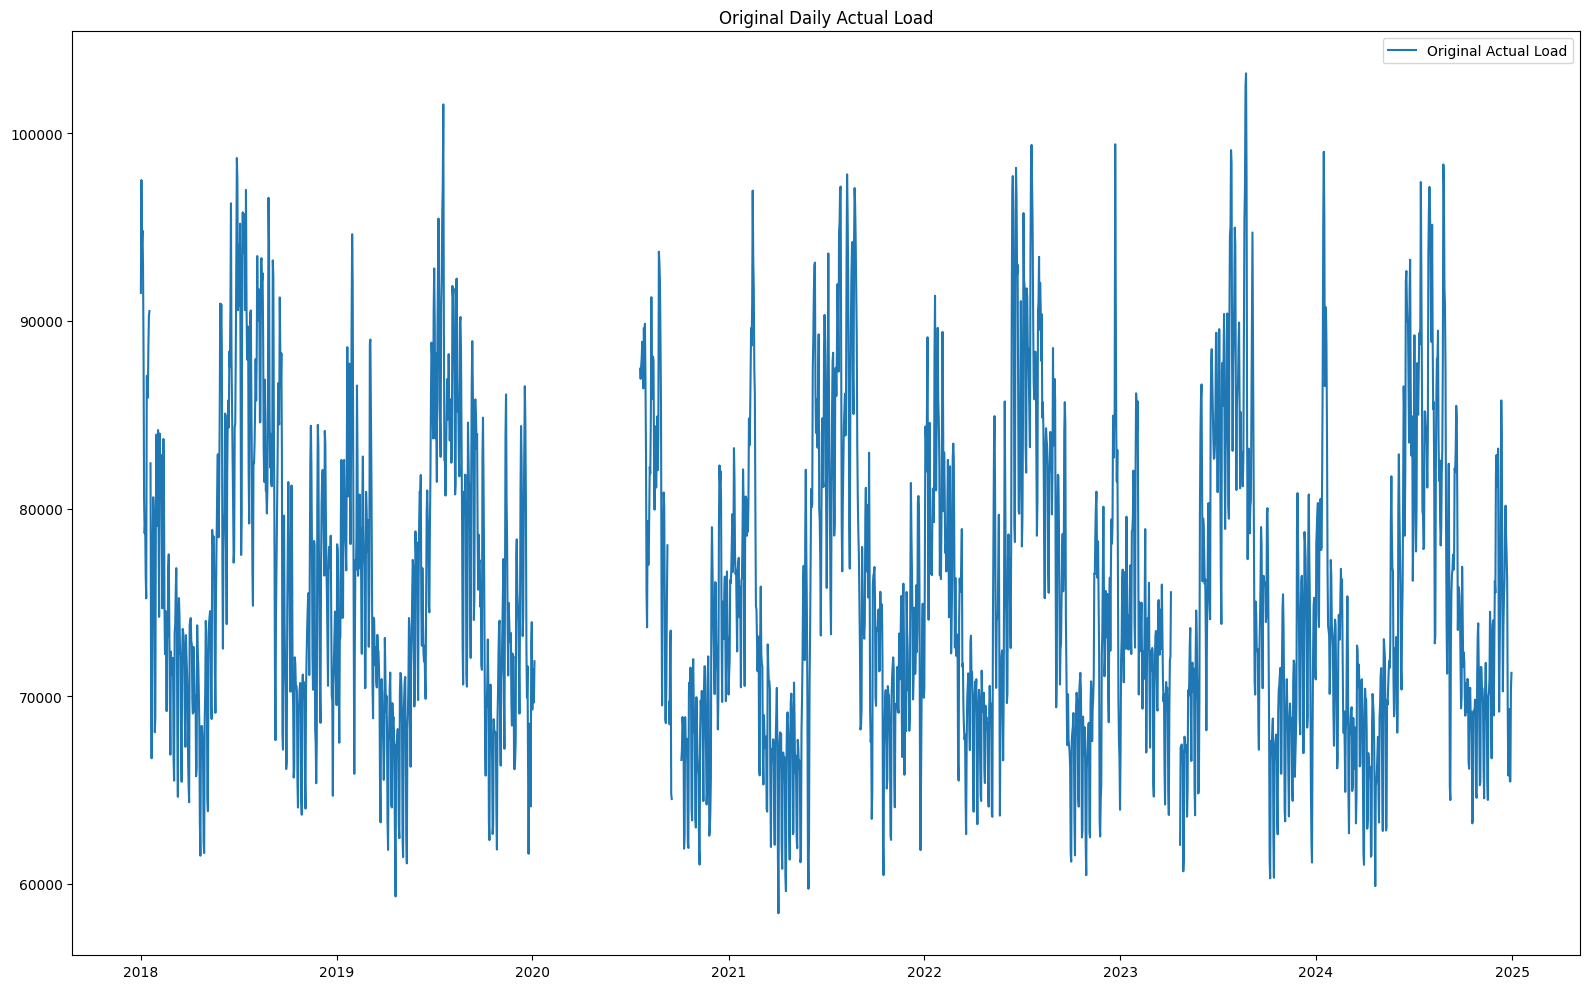

In [ ]:

plt.figure(figsize=(16, 10))
plt.plot(daily_actual, label='Original Actual Load')
plt.title('Original Daily Actual Load')
plt.legend()
plt.tight_layout()
plt.show()

*Plot ACF and PACF to identify potential ARIMA parameters*


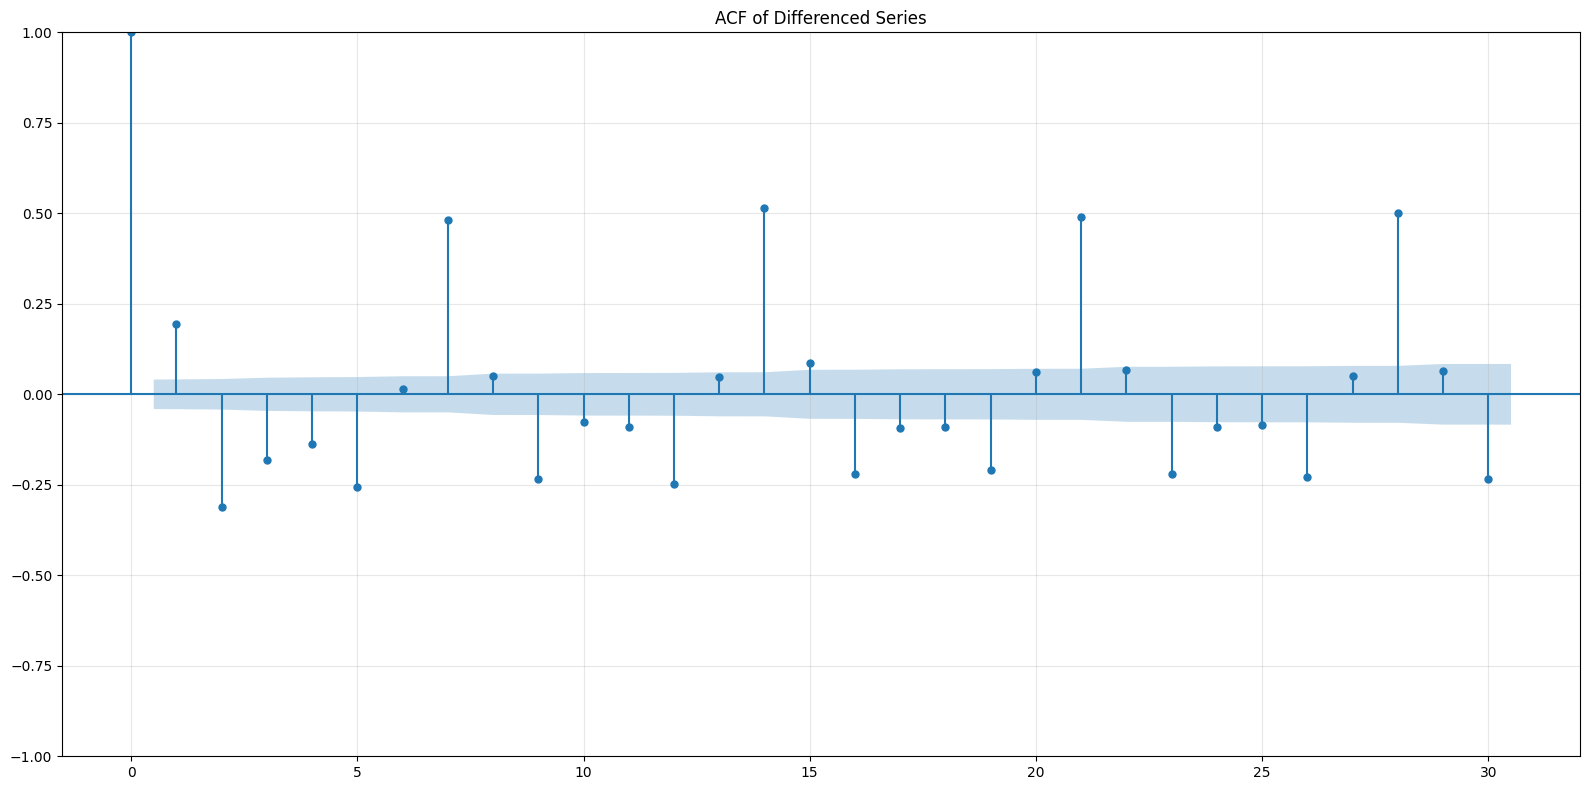

In [ ]:
plt.figure(figsize=(16, 8))
plot_acf(daily_actual_diff, ax=plt.gca(), lags=30)
plt.title('ACF of Differenced Series')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

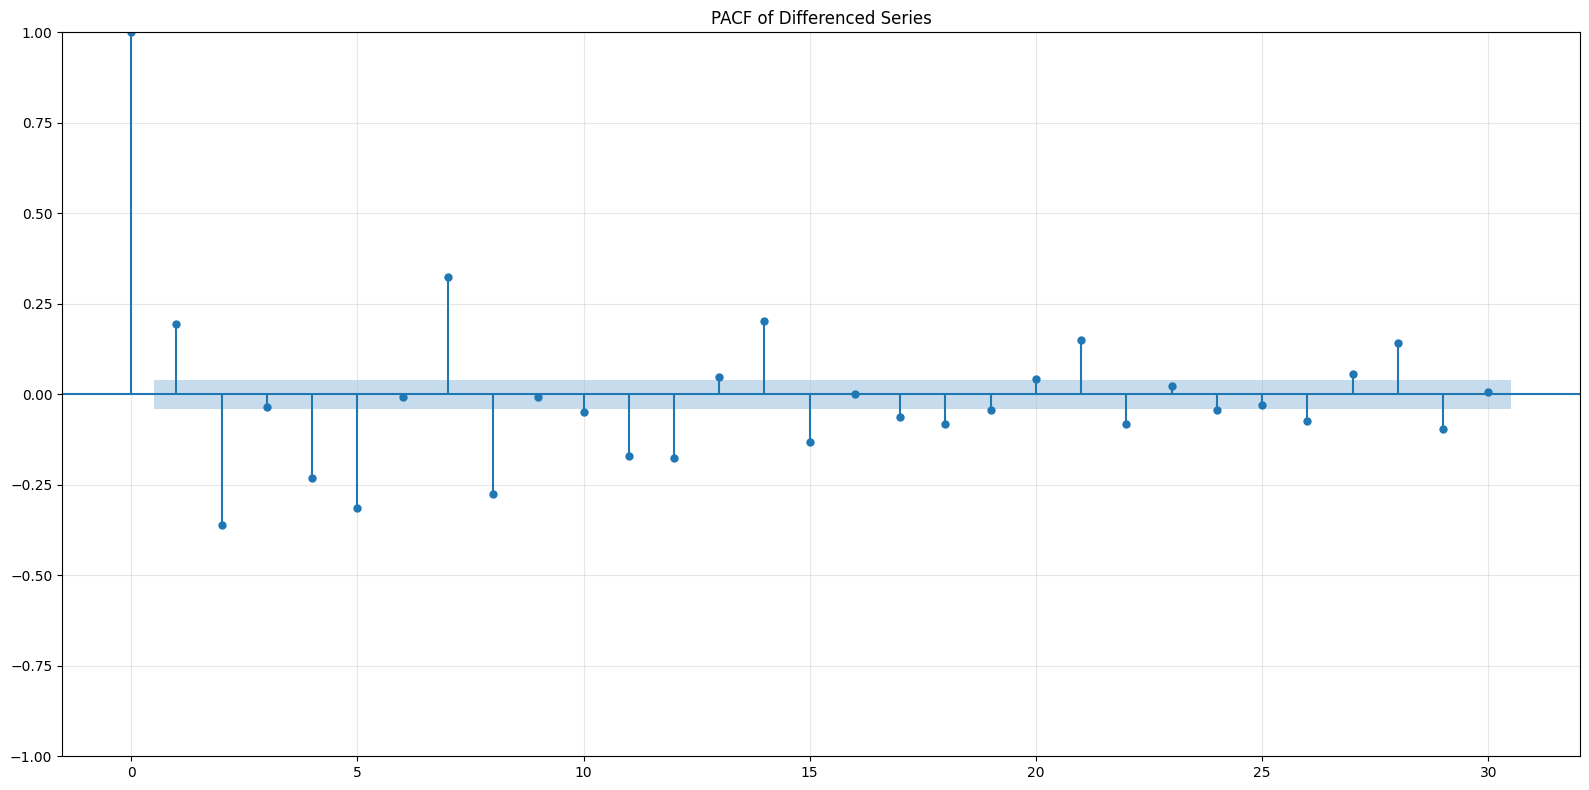

In [ ]:
plt.figure(figsize=(16, 8))
plot_pacf(daily_actual_diff, ax=plt.gca(), lags=30)
plt.title('PACF of Differenced Series')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ARIMA Model

In [ ]:
# Split data for training and testing
train_size = int(len(daily_actual) * 0.8)
train_data = daily_actual[:train_size]
test_data = daily_actual[train_size:]

print(f"Training data: {train_data.index.min()} to {train_data.index.max()}")
print(f"Testing data: {test_data.index.min()} to {test_data.index.max()}")

Training data: 2018-01-01 00:00:00 to 2023-08-07 00:00:00
Testing data: 2023-08-08 00:00:00 to 2024-12-31 00:00:00


In [ ]:
# Fit ARIMA model
# p: AR order, d: differencing, q: MA order
p, d, q = 1, 0, 1

ARIMA_model = ARIMA(train_data, order=(p, d, q))
ARIMA_fitted_model = ARIMA_model.fit()
print(ARIMA_fitted_model.summary())

                               SARIMAX Results                                
Dep. Variable:             ActualLoad   No. Observations:                 2045
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -17431.672
Date:                Thu, 13 Mar 2025   AIC                          34871.343
Time:                        23:01:59   BIC                          34893.836
Sample:                    01-01-2018   HQIC                         34879.593
                         - 08-07-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.627e+04    666.400    114.451      0.000     7.5e+04    7.76e+04
ar.L1          0.7957      0.015     51.710      0.000       0.766       0.826
ma.L1          0.4784      0.025     18.801      0.0

*The model fits okay, but there are some issues with residuals. The Ljung-Box tests suggests the model isn't fully capturing the time-series structure. The Jarque-Bera test shows that the residuals aren't normally distributed. Conclusion: It might be better to use a  seasonal model like Prophet*

# Prophet Model

In [ ]:
prophet_data = daily_actual.reset_index()

prophet_data.columns = ['ds', 'y']

In [ ]:
train_prophet = prophet_data.iloc[:train_size]
test_prophet = prophet_data.iloc[train_size:]

In [ ]:
# Initialize and fit Prophet model
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    changepoint_prior_scale=0.05  # Flexibility of the trend
)
model.fit(train_prophet)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/jr8pl0ga.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/blrun_8s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24773', 'data', 'file=/tmp/tmp7iwbzjog/jr8pl0ga.json', 'init=/tmp/tmp7iwbzjog/blrun_8s.json', 'output', 'file=/tmp/tmp7iwbzjog/prophet_model7706j6sd/prophet_model-20250313232900.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:29:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:29:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Create future dataframe for prediction
future = model.make_future_dataframe(periods=len(test_prophet), freq='D')
forecast = model.predict(future)

In [ ]:
# Extract forecast for test period
prophet_forecast = forecast.loc[forecast['ds'].isin(test_prophet['ds']), 'yhat']

In [ ]:
# Calculate error metrics
prophet_mse = mean_squared_error(test_prophet['y'], prophet_forecast)
prophet_rmse = np.sqrt(prophet_mse)
prophet_mae = mean_absolute_error(test_prophet['y'], prophet_forecast)
prophet_mape = mean_absolute_percentage_error(test_prophet['y'], prophet_forecast) * 100

print(f"\nProphet Model Performance:")
print(f"MSE: {prophet_mse:.2f}")
print(f"RMSE: {prophet_rmse:.2f}")
print(f"MAE: {prophet_mae:.2f}")
print(f"MAPE: {prophet_mape:.2f}%")
print(f"RMSE as percentage of mean: {prophet_rmse/test_prophet['y'].mean()*100:.2f}%")


Prophet Model Performance:
MSE: 26457540.21
RMSE: 5143.69
MAE: 3855.77
MAPE: 4.96%
RMSE as percentage of mean: 6.87%


In [ ]:
# Get the MISO forecasted load for the test period
miso_forecast_test = daily_forecast[test_prophet['ds']]
miso_cleared_test = daily_cleared[test_prophet['ds']]

In [ ]:
# Calculate MISO forecast performance
miso_forecast_mse = mean_squared_error(test_prophet['y'], miso_forecast_test.values)
miso_forecast_rmse = np.sqrt(miso_forecast_mse)
miso_forecast_mae = mean_absolute_error(test_prophet['y'], miso_forecast_test.values)
miso_forecast_mape = mean_absolute_percentage_error(test_prophet['y'], miso_forecast_test.values) * 100

print(f"\nMISO Forecast Performance:")
print(f"MSE: {miso_forecast_mse:.2f}")
print(f"RMSE: {miso_forecast_rmse:.2f}")
print(f"MAE: {miso_forecast_mae:.2f}")
print(f"MAPE: {miso_forecast_mape:.2f}%")
print(f"RMSE as percentage of mean: {miso_forecast_rmse/test_prophet['y'].mean()*100:.2f}%")



MISO Forecast Performance:
MSE: 1195413.86
RMSE: 1093.35
MAE: 843.38
MAPE: 1.11%
RMSE as percentage of mean: 1.46%


In [ ]:
# Calculate cleared load performance
cleared_mse = mean_squared_error(test_prophet['y'], miso_cleared_test.values)
cleared_rmse = np.sqrt(cleared_mse)
cleared_mae = mean_absolute_error(test_prophet['y'], miso_cleared_test.values)
cleared_mape = mean_absolute_percentage_error(test_prophet['y'], miso_cleared_test.values) * 100

print(f"\nCleared Load Performance:")
print(f"MSE: {cleared_mse:.2f}")
print(f"RMSE: {cleared_rmse:.2f}")
print(f"MAE: {cleared_mae:.2f}")
print(f"MAPE: {cleared_mape:.2f}%")
print(f"RMSE as percentage of mean: {cleared_rmse/test_prophet['y'].mean()*100:.2f}%")


Cleared Load Performance:
MSE: 2820335.17
RMSE: 1679.39
MAE: 1276.32
MAPE: 1.67%
RMSE as percentage of mean: 2.24%


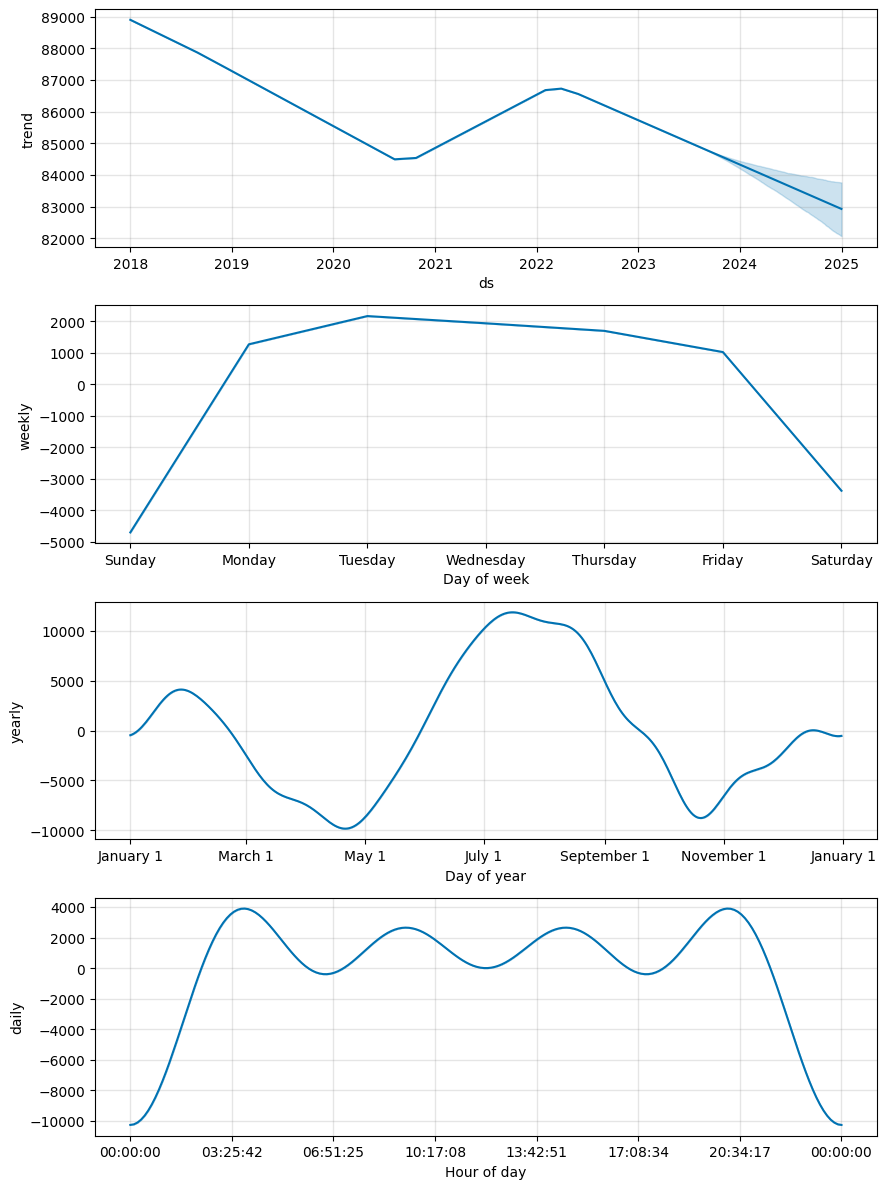

In [ ]:
# Plot Prophet components
fig = model.plot_components(forecast)
plt.show()

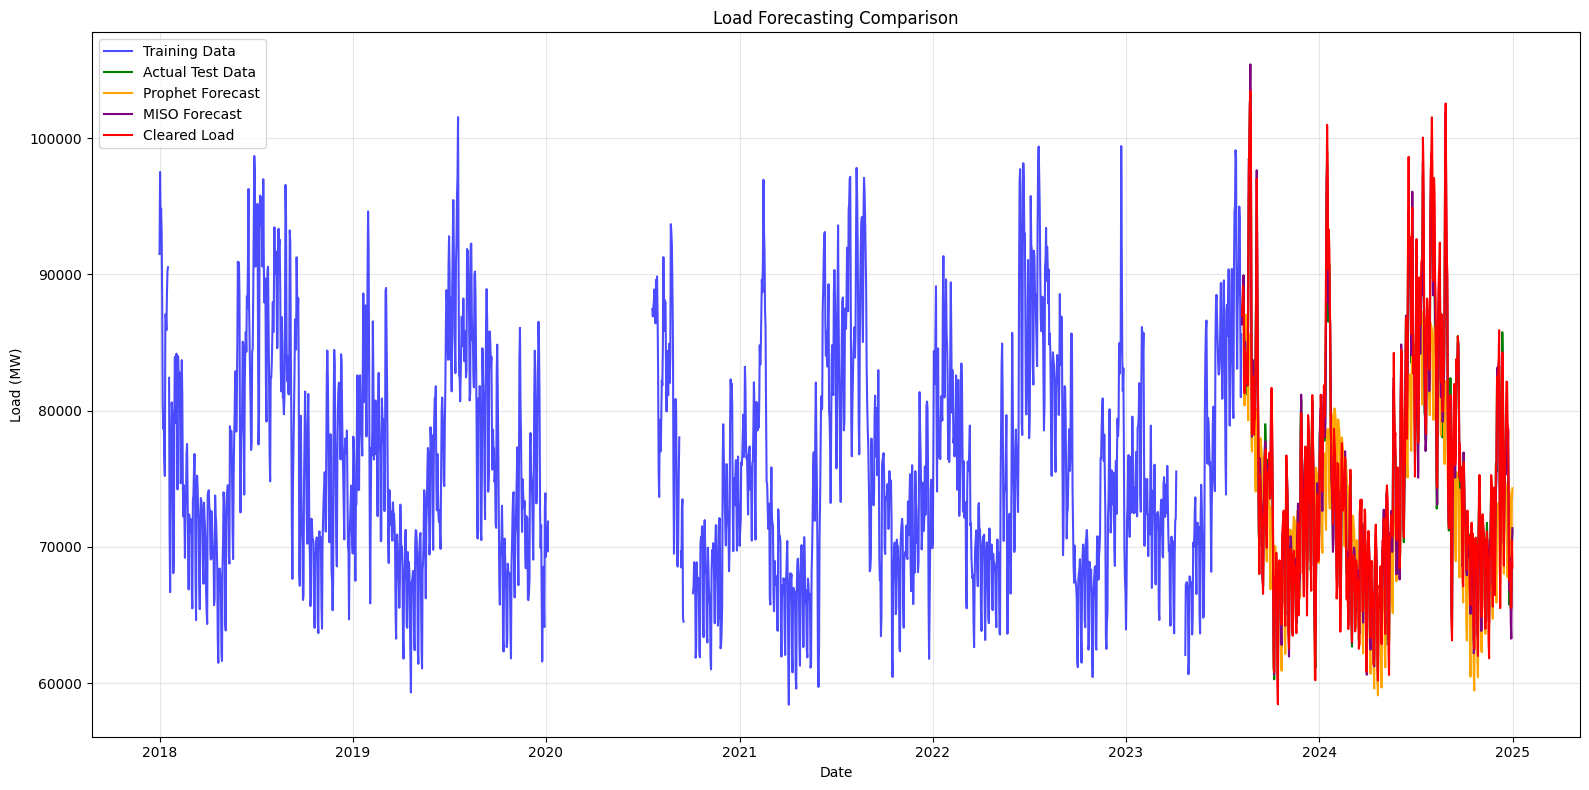

In [ ]:
# Plot actual vs forecasted values
plt.figure(figsize=(16, 8))
plt.plot(train_prophet['ds'], train_prophet['y'], label='Training Data', color='blue', alpha=0.7)
plt.plot(test_prophet['ds'], test_prophet['y'], label='Actual Test Data', color='green')
plt.plot(test_prophet['ds'], prophet_forecast, label='Prophet Forecast', color='orange')
plt.plot(test_prophet['ds'], miso_forecast_test.values, label='MISO Forecast', color='purple')
plt.plot(test_prophet['ds'], miso_cleared_test.values, label='Cleared Load', color='red')
plt.xlabel('Date')
plt.ylabel('Load (MW)')
plt.title('Load Forecasting Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

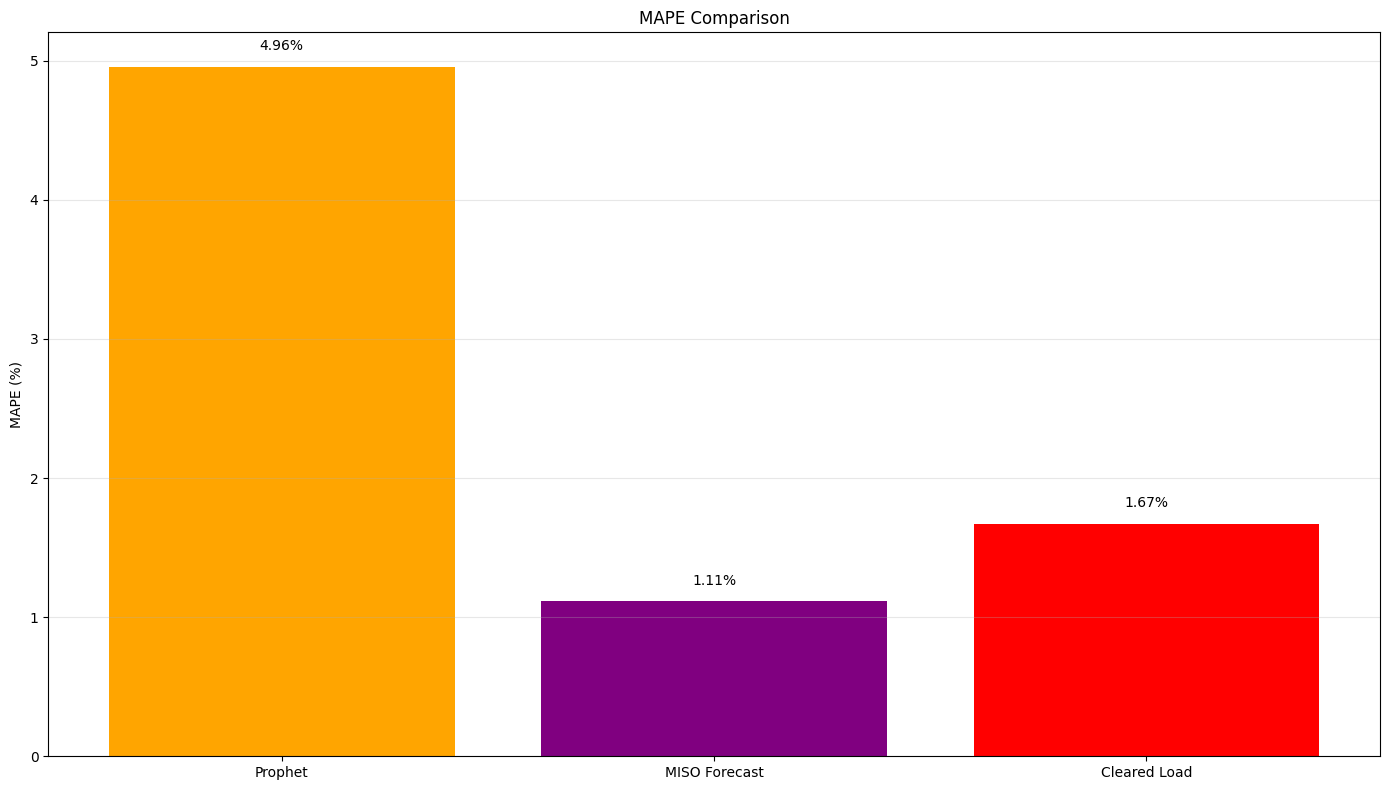

In [ ]:
# Compare models using bar chart
model_names = ['Prophet', 'MISO Forecast', 'Cleared Load']
rmse_values = [prophet_rmse, miso_forecast_rmse, cleared_rmse]
mape_values = [prophet_mape, miso_forecast_mape, cleared_mape]

plt.figure(figsize=(14, 8))
bars = plt.bar(model_names, mape_values, color=['orange', 'purple', 'red'])
plt.title('MAPE Comparison')
plt.ylabel('MAPE (%)')
plt.grid(True, axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{height:.2f}%', ha='center', va='bottom')
plt.tight_layout()
plt.show()

In [ ]:
# Try different hyperparameters for Prophet
def evaluate_prophet_model(changepoint_scales, seasonality_scales, seasonality_modes):
    best_score, best_params = float('inf'), None
    results = []

    for cp_scale in changepoint_scales:
        for seas_scale in seasonality_scales:
            for seas_mode in seasonality_modes:
                try:
                    model = Prophet(
                        yearly_seasonality=True,
                        weekly_seasonality=True,
                        daily_seasonality=True,
                        changepoint_prior_scale=cp_scale,
                        seasonality_prior_scale=seas_scale,
                        seasonality_mode=seas_mode
                    )
                    model.fit(train_prophet)
                    future = model.make_future_dataframe(periods=len(test_prophet), freq='D')
                    forecast = model.predict(future)
                    prophet_forecast = forecast.loc[forecast['ds'].isin(test_prophet['ds']), 'yhat']

                    mse = mean_squared_error(test_prophet['y'], prophet_forecast)
                    rmse = np.sqrt(mse)
                    mape = mean_absolute_percentage_error(test_prophet['y'], prophet_forecast) * 100

                    results.append((cp_scale, seas_scale, seas_mode, rmse, mape))

                    if rmse < best_score:
                        best_score = rmse
                        best_params = (cp_scale, seas_scale, seas_mode)

                    print(f"Prophet(cp={cp_scale}, seas={seas_scale}, mode={seas_mode}) - RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")
                except Exception as e:
                    print(f"Error with parameters cp={cp_scale}, seas={seas_scale}, mode={seas_mode}: {e}")
                    continue

    results_df = pd.DataFrame(results, columns=['changepoint_scale', 'seasonality_scale', 'seasonality_mode', 'RMSE', 'MAPE'])
    return results_df.sort_values('RMSE'), best_params

# Try different Prophet hyperparameters
changepoint_scales = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
seasonality_scales = [0.1, 1, 5, 10, 20]
seasonality_modes = ['additive', 'multiplicative']

print("Evaluating different Prophet hyperparameters...")
results_df, best_params = evaluate_prophet_model(changepoint_scales, seasonality_scales, seasonality_modes)
print("\nTop 5 Prophet models:")
print(results_df.head())
print(f"Best parameters: changepoint_scale={best_params[0]}, seasonality_scale={best_params[1]}, seasonality_mode={best_params[2]}")


DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/pjlhu85l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/d6f7nwur.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97209', 'data', 'file=/tmp/tmp7iwbzjog/pjlhu85l.json', 'init=/tmp/tmp7iwbzjog/d6f7nwur.json', 'output', 'file=/tmp/tmp7iwbzjog/prophet_model3fq6anpx/prophet_model-20250313233235.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:32:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Evaluating different Prophet hyperparameters...


23:32:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/0i3rg55p.json


Prophet(cp=0.001, seas=0.1, mode=additive) - RMSE: 4947.42, MAPE: 4.80%


DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/aynkm52r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62792', 'data', 'file=/tmp/tmp7iwbzjog/0i3rg55p.json', 'init=/tmp/tmp7iwbzjog/aynkm52r.json', 'output', 'file=/tmp/tmp7iwbzjog/prophet_modelv0jpr7im/prophet_model-20250313233236.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:32:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:32:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/5dyo_lz9.json


Prophet(cp=0.001, seas=0.1, mode=multiplicative) - RMSE: 5001.79, MAPE: 4.77%


DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/7bdv42um.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44339', 'data', 'file=/tmp/tmp7iwbzjog/5dyo_lz9.json', 'init=/tmp/tmp7iwbzjog/7bdv42um.json', 'output', 'file=/tmp/tmp7iwbzjog/prophet_modelooo53bp3/prophet_model-20250313233238.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:32:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:32:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/cm8epb41.json


Prophet(cp=0.001, seas=1, mode=additive) - RMSE: 4951.10, MAPE: 4.79%


DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/yzp6bxcr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32851', 'data', 'file=/tmp/tmp7iwbzjog/cm8epb41.json', 'init=/tmp/tmp7iwbzjog/yzp6bxcr.json', 'output', 'file=/tmp/tmp7iwbzjog/prophet_modelbff4qcjs/prophet_model-20250313233239.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:32:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:32:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/yu78toty.json


Prophet(cp=0.001, seas=1, mode=multiplicative) - RMSE: 4973.71, MAPE: 4.76%


DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/vtodtxfj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41314', 'data', 'file=/tmp/tmp7iwbzjog/yu78toty.json', 'init=/tmp/tmp7iwbzjog/vtodtxfj.json', 'output', 'file=/tmp/tmp7iwbzjog/prophet_modelyx_fh6oi/prophet_model-20250313233241.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:32:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:32:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/zjbokjhm.json


Prophet(cp=0.001, seas=5, mode=additive) - RMSE: 4969.05, MAPE: 4.79%


DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/103sf191.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37231', 'data', 'file=/tmp/tmp7iwbzjog/zjbokjhm.json', 'init=/tmp/tmp7iwbzjog/103sf191.json', 'output', 'file=/tmp/tmp7iwbzjog/prophet_modeljtt6ia7y/prophet_model-20250313233243.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:32:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:32:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/fbzhvf3w.json


Prophet(cp=0.001, seas=5, mode=multiplicative) - RMSE: 4968.88, MAPE: 4.76%


DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/sed0u9us.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84006', 'data', 'file=/tmp/tmp7iwbzjog/fbzhvf3w.json', 'init=/tmp/tmp7iwbzjog/sed0u9us.json', 'output', 'file=/tmp/tmp7iwbzjog/prophet_modelhwjtgrq0/prophet_model-20250313233245.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:32:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:32:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/8kmhl1wl.json


Prophet(cp=0.001, seas=10, mode=additive) - RMSE: 4942.10, MAPE: 4.79%


DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/1knoan_p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27111', 'data', 'file=/tmp/tmp7iwbzjog/8kmhl1wl.json', 'init=/tmp/tmp7iwbzjog/1knoan_p.json', 'output', 'file=/tmp/tmp7iwbzjog/prophet_modelyak0zafw/prophet_model-20250313233247.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:32:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:32:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/yxj2ggk6.json


Prophet(cp=0.001, seas=10, mode=multiplicative) - RMSE: 4990.30, MAPE: 4.77%


DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/71le7gct.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30400', 'data', 'file=/tmp/tmp7iwbzjog/yxj2ggk6.json', 'init=/tmp/tmp7iwbzjog/71le7gct.json', 'output', 'file=/tmp/tmp7iwbzjog/prophet_model4o4dcu80/prophet_model-20250313233248.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:32:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:32:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/lazl4ksd.json


Prophet(cp=0.001, seas=20, mode=additive) - RMSE: 4941.12, MAPE: 4.78%


DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/x8t0n07w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19784', 'data', 'file=/tmp/tmp7iwbzjog/lazl4ksd.json', 'init=/tmp/tmp7iwbzjog/x8t0n07w.json', 'output', 'file=/tmp/tmp7iwbzjog/prophet_model884fzowo/prophet_model-20250313233249.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:32:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:32:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/baq8e3gf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/j_y8lk_n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.b

Prophet(cp=0.001, seas=20, mode=multiplicative) - RMSE: 4985.43, MAPE: 4.76%


23:32:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/z3c97gc7.json


Prophet(cp=0.005, seas=0.1, mode=additive) - RMSE: 4889.04, MAPE: 4.81%


DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/_9427u3z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67883', 'data', 'file=/tmp/tmp7iwbzjog/z3c97gc7.json', 'init=/tmp/tmp7iwbzjog/_9427u3z.json', 'output', 'file=/tmp/tmp7iwbzjog/prophet_modelb788ektg/prophet_model-20250313233252.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:32:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:32:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/c77_kskc.json


Prophet(cp=0.005, seas=0.1, mode=multiplicative) - RMSE: 4891.04, MAPE: 4.79%


DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/bda__wpb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36581', 'data', 'file=/tmp/tmp7iwbzjog/c77_kskc.json', 'init=/tmp/tmp7iwbzjog/bda__wpb.json', 'output', 'file=/tmp/tmp7iwbzjog/prophet_modeljp1j1bvh/prophet_model-20250313233253.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:32:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:32:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/l5l27yif.json


Prophet(cp=0.005, seas=1, mode=additive) - RMSE: 4889.97, MAPE: 4.82%


DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/_vjqgubi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71732', 'data', 'file=/tmp/tmp7iwbzjog/l5l27yif.json', 'init=/tmp/tmp7iwbzjog/_vjqgubi.json', 'output', 'file=/tmp/tmp7iwbzjog/prophet_modely84x4_yl/prophet_model-20250313233255.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:32:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:32:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/phnmhvi9.json


Prophet(cp=0.005, seas=1, mode=multiplicative) - RMSE: 4889.62, MAPE: 4.80%


DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/bfgainwy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59932', 'data', 'file=/tmp/tmp7iwbzjog/phnmhvi9.json', 'init=/tmp/tmp7iwbzjog/bfgainwy.json', 'output', 'file=/tmp/tmp7iwbzjog/prophet_modelkhljeprm/prophet_model-20250313233256.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:32:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:32:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/6_5l7j7m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/tbs9_fhi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.b

Prophet(cp=0.005, seas=5, mode=additive) - RMSE: 4888.82, MAPE: 4.81%


23:32:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/ckpqfv6c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/642ur38f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40638', 'data', 'file=/tmp/tmp7iwbzjog/ckpqfv6c.json', 'init=/tmp/tmp7iwbzjog/642ur38f.json', 'output', 'file=/tmp/tmp7iwbzjog/prophet_modellnje29et/prophet_model-20250313233258.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:32:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Prophet(cp=0.005, seas=5, mode=multiplicative) - RMSE: 4890.43, MAPE: 4.79%


23:32:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/e4jhkf1w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/qjt2qgjy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82488', 'data', 'file=/tmp/tmp7iwbzjog/e4jhkf1w.json', 'init=/tmp/tmp7iwbzjog/qjt2qgjy.json', 'output', 'file=/tmp/tmp7iwbzjog/prophet_modelugbhdx8m/prophet_model-20250313233259.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:32:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Prophet(cp=0.005, seas=10, mode=additive) - RMSE: 4888.75, MAPE: 4.81%


23:32:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/qipya1fm.json


Prophet(cp=0.005, seas=10, mode=multiplicative) - RMSE: 4891.27, MAPE: 4.78%


DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/2me2bdhh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18465', 'data', 'file=/tmp/tmp7iwbzjog/qipya1fm.json', 'init=/tmp/tmp7iwbzjog/2me2bdhh.json', 'output', 'file=/tmp/tmp7iwbzjog/prophet_modelwdbgvm9d/prophet_model-20250313233300.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:33:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:33:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/wx70w08u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/vu0_nnqx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.b

Prophet(cp=0.005, seas=20, mode=additive) - RMSE: 4889.75, MAPE: 4.82%


23:33:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/l3hmg93n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/hh2r0l8w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26018', 'data', 'file=/tmp/tmp7iwbzjog/l3hmg93n.json', 'init=/tmp/tmp7iwbzjog/hh2r0l8w.json', 'output', 'file=/tmp/tmp7iwbzjog/prophet_model3oahgvla/prophet_model-20250313233302.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:33:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Prophet(cp=0.005, seas=20, mode=multiplicative) - RMSE: 4889.96, MAPE: 4.79%


23:33:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/bd1rb2ru.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/r1u0dtlk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38732', 'data', 'file=/tmp/tmp7iwbzjog/bd1rb2ru.json', 'init=/tmp/tmp7iwbzjog/r1u0dtlk.json', 'output', 'file=/tmp/tmp7iwbzjog/prophet_modelvxvunv75/prophet_model-20250313233303.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:33:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Prophet(cp=0.01, seas=0.1, mode=additive) - RMSE: 4907.66, MAPE: 4.89%


23:33:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/oi_4fdmc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/pibew53i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31679', 'data', 'file=/tmp/tmp7iwbzjog/oi_4fdmc.json', 'init=/tmp/tmp7iwbzjog/pibew53i.json', 'output', 'file=/tmp/tmp7iwbzjog/prophet_model4bo4z77k/prophet_model-20250313233304.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:33:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Prophet(cp=0.01, seas=0.1, mode=multiplicative) - RMSE: 4901.45, MAPE: 4.87%


23:33:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/ymmc38aa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/byhn25dr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58844', 'data', 'file=/tmp/tmp7iwbzjog/ymmc38aa.json', 'init=/tmp/tmp7iwbzjog/byhn25dr.json', 'output', 'file=/tmp/tmp7iwbzjog/prophet_modeln895e0f6/prophet_model-20250313233305.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:33:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Prophet(cp=0.01, seas=1, mode=additive) - RMSE: 4906.89, MAPE: 4.89%


23:33:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/q3hkpqvo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/yclzbgpe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33585', 'data', 'file=/tmp/tmp7iwbzjog/q3hkpqvo.json', 'init=/tmp/tmp7iwbzjog/yclzbgpe.json', 'output', 'file=/tmp/tmp7iwbzjog/prophet_modelbicjzuvj/prophet_model-20250313233306.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:33:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Prophet(cp=0.01, seas=1, mode=multiplicative) - RMSE: 4905.14, MAPE: 4.88%


23:33:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/7366oowj.json


Prophet(cp=0.01, seas=5, mode=additive) - RMSE: 4907.24, MAPE: 4.89%


DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/o5xknvj5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23562', 'data', 'file=/tmp/tmp7iwbzjog/7366oowj.json', 'init=/tmp/tmp7iwbzjog/o5xknvj5.json', 'output', 'file=/tmp/tmp7iwbzjog/prophet_modelkgc90uhb/prophet_model-20250313233307.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:33:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:33:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/t9ccp4ck.json


Prophet(cp=0.01, seas=5, mode=multiplicative) - RMSE: 4905.89, MAPE: 4.88%


DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/0sb003lk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34265', 'data', 'file=/tmp/tmp7iwbzjog/t9ccp4ck.json', 'init=/tmp/tmp7iwbzjog/0sb003lk.json', 'output', 'file=/tmp/tmp7iwbzjog/prophet_modelxcsdzzqz/prophet_model-20250313233309.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:33:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:33:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/34ugk9s4.json


Prophet(cp=0.01, seas=10, mode=additive) - RMSE: 4908.58, MAPE: 4.89%


DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/vbp9omxw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66511', 'data', 'file=/tmp/tmp7iwbzjog/34ugk9s4.json', 'init=/tmp/tmp7iwbzjog/vbp9omxw.json', 'output', 'file=/tmp/tmp7iwbzjog/prophet_modelek8t4ub9/prophet_model-20250313233310.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:33:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:33:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/223velym.json


Prophet(cp=0.01, seas=10, mode=multiplicative) - RMSE: 4904.09, MAPE: 4.88%


DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/fm6t2ngi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50518', 'data', 'file=/tmp/tmp7iwbzjog/223velym.json', 'init=/tmp/tmp7iwbzjog/fm6t2ngi.json', 'output', 'file=/tmp/tmp7iwbzjog/prophet_model1gl7m18k/prophet_model-20250313233312.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:33:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:33:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/oxypp5n6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/jbm60j1o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.b

Prophet(cp=0.01, seas=20, mode=additive) - RMSE: 4908.13, MAPE: 4.89%


23:33:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/7f39umrn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/a53dr408.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5485', 'data', 'file=/tmp/tmp7iwbzjog/7f39umrn.json', 'init=/tmp/tmp7iwbzjog/a53dr408.json', 'output', 'file=/tmp/tmp7iwbzjog/prophet_modelzu21921_/prophet_model-20250313233314.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:33:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Prophet(cp=0.01, seas=20, mode=multiplicative) - RMSE: 4904.80, MAPE: 4.88%


23:33:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/jijm3f6p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/0rdgvjym.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59281', 'data', 'file=/tmp/tmp7iwbzjog/jijm3f6p.json', 'init=/tmp/tmp7iwbzjog/0rdgvjym.json', 'output', 'file=/tmp/tmp7iwbzjog/prophet_modeldfz7y17_/prophet_model-20250313233315.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:33:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Prophet(cp=0.05, seas=0.1, mode=additive) - RMSE: 5219.33, MAPE: 5.03%


23:33:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/tjwiptc6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/v4qsal56.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3671', 'data', 'file=/tmp/tmp7iwbzjog/tjwiptc6.json', 'init=/tmp/tmp7iwbzjog/v4qsal56.json', 'output', 'file=/tmp/tmp7iwbzjog/prophet_modelo5cfcu9v/prophet_model-20250313233316.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:33:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Prophet(cp=0.05, seas=0.1, mode=multiplicative) - RMSE: 5133.53, MAPE: 4.89%


23:33:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/d5fwnqhr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/xut89tvm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84194', 'data', 'file=/tmp/tmp7iwbzjog/d5fwnqhr.json', 'init=/tmp/tmp7iwbzjog/xut89tvm.json', 'output', 'file=/tmp/tmp7iwbzjog/prophet_modellmaz4p3x/prophet_model-20250313233317.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:33:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Prophet(cp=0.05, seas=1, mode=additive) - RMSE: 5180.89, MAPE: 4.99%


23:33:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/fxy7t0_9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/us7x_qj5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88986', 'data', 'file=/tmp/tmp7iwbzjog/fxy7t0_9.json', 'init=/tmp/tmp7iwbzjog/us7x_qj5.json', 'output', 'file=/tmp/tmp7iwbzjog/prophet_modeltb0jwdlg/prophet_model-20250313233318.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:33:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Prophet(cp=0.05, seas=1, mode=multiplicative) - RMSE: 5155.61, MAPE: 4.91%


23:33:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/4ek3g5b2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/5lhzw048.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10103', 'data', 'file=/tmp/tmp7iwbzjog/4ek3g5b2.json', 'init=/tmp/tmp7iwbzjog/5lhzw048.json', 'output', 'file=/tmp/tmp7iwbzjog/prophet_modelkr_1bjyp/prophet_model-20250313233319.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:33:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Prophet(cp=0.05, seas=5, mode=additive) - RMSE: 5192.91, MAPE: 5.00%


23:33:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/vnzzyzft.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/bymqg5v4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84355', 'data', 'file=/tmp/tmp7iwbzjog/vnzzyzft.json', 'init=/tmp/tmp7iwbzjog/bymqg5v4.json', 'output', 'file=/tmp/tmp7iwbzjog/prophet_modellbsot6xu/prophet_model-20250313233320.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:33:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Prophet(cp=0.05, seas=5, mode=multiplicative) - RMSE: 5139.98, MAPE: 4.89%


23:33:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/scs70lvd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/1q748he1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11152', 'data', 'file=/tmp/tmp7iwbzjog/scs70lvd.json', 'init=/tmp/tmp7iwbzjog/1q748he1.json', 'output', 'file=/tmp/tmp7iwbzjog/prophet_model1rrip7u6/prophet_model-20250313233321.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:33:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Prophet(cp=0.05, seas=10, mode=additive) - RMSE: 5143.69, MAPE: 4.96%


23:33:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/x64cfwu2.json


Prophet(cp=0.05, seas=10, mode=multiplicative) - RMSE: 5136.43, MAPE: 4.89%


DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/oypbn63q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74732', 'data', 'file=/tmp/tmp7iwbzjog/x64cfwu2.json', 'init=/tmp/tmp7iwbzjog/oypbn63q.json', 'output', 'file=/tmp/tmp7iwbzjog/prophet_modelwpy4ykmn/prophet_model-20250313233322.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:33:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:33:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/4wrpgp2b.json


Prophet(cp=0.05, seas=20, mode=additive) - RMSE: 5192.14, MAPE: 5.00%


DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/gimrebyn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74484', 'data', 'file=/tmp/tmp7iwbzjog/4wrpgp2b.json', 'init=/tmp/tmp7iwbzjog/gimrebyn.json', 'output', 'file=/tmp/tmp7iwbzjog/prophet_modelik9cxezp/prophet_model-20250313233323.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:33:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:33:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/5ja2eg_s.json


Prophet(cp=0.05, seas=20, mode=multiplicative) - RMSE: 5136.40, MAPE: 4.89%


DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/gyhm70ry.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52604', 'data', 'file=/tmp/tmp7iwbzjog/5ja2eg_s.json', 'init=/tmp/tmp7iwbzjog/gyhm70ry.json', 'output', 'file=/tmp/tmp7iwbzjog/prophet_model2mv8nlbu/prophet_model-20250313233325.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:33:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:33:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/9omrt3iv.json


Prophet(cp=0.1, seas=0.1, mode=additive) - RMSE: 5242.91, MAPE: 5.06%


DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/sw1x9p48.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22271', 'data', 'file=/tmp/tmp7iwbzjog/9omrt3iv.json', 'init=/tmp/tmp7iwbzjog/sw1x9p48.json', 'output', 'file=/tmp/tmp7iwbzjog/prophet_model222x9nbv/prophet_model-20250313233327.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:33:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:33:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/7qgw5qe1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/_4afb2yg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.b

Prophet(cp=0.1, seas=0.1, mode=multiplicative) - RMSE: 5206.80, MAPE: 4.95%


23:33:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/3makcb9k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/hcinjjrh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50477', 'data', 'file=/tmp/tmp7iwbzjog/3makcb9k.json', 'init=/tmp/tmp7iwbzjog/hcinjjrh.json', 'output', 'file=/tmp/tmp7iwbzjog/prophet_model8o6mwngh/prophet_model-20250313233329.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:33:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Prophet(cp=0.1, seas=1, mode=additive) - RMSE: 5254.21, MAPE: 5.07%


23:33:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/l428jz0a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/1ki8btcl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81957', 'data', 'file=/tmp/tmp7iwbzjog/l428jz0a.json', 'init=/tmp/tmp7iwbzjog/1ki8btcl.json', 'output', 'file=/tmp/tmp7iwbzjog/prophet_modelos0y_3mi/prophet_model-20250313233330.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:33:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Prophet(cp=0.1, seas=1, mode=multiplicative) - RMSE: 5214.70, MAPE: 4.96%


23:33:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/828f365z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/lsv04xkw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40432', 'data', 'file=/tmp/tmp7iwbzjog/828f365z.json', 'init=/tmp/tmp7iwbzjog/lsv04xkw.json', 'output', 'file=/tmp/tmp7iwbzjog/prophet_modelg7rag6qv/prophet_model-20250313233331.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:33:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Prophet(cp=0.1, seas=5, mode=additive) - RMSE: 5245.81, MAPE: 5.06%


23:33:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/wzf7ov6u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/frj_6qxc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88586', 'data', 'file=/tmp/tmp7iwbzjog/wzf7ov6u.json', 'init=/tmp/tmp7iwbzjog/frj_6qxc.json', 'output', 'file=/tmp/tmp7iwbzjog/prophet_modelujcgbmwo/prophet_model-20250313233334.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:33:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Prophet(cp=0.1, seas=5, mode=multiplicative) - RMSE: 4996.05, MAPE: 4.74%


23:33:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/myiucn5m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/g7tk31yl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19884', 'data', 'file=/tmp/tmp7iwbzjog/myiucn5m.json', 'init=/tmp/tmp7iwbzjog/g7tk31yl.json', 'output', 'file=/tmp/tmp7iwbzjog/prophet_model_eep_3p0/prophet_model-20250313233335.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:33:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Prophet(cp=0.1, seas=10, mode=additive) - RMSE: 5270.63, MAPE: 5.09%


23:33:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/n9xodxyi.json


Prophet(cp=0.1, seas=10, mode=multiplicative) - RMSE: 4979.85, MAPE: 4.74%


DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/419memgb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15311', 'data', 'file=/tmp/tmp7iwbzjog/n9xodxyi.json', 'init=/tmp/tmp7iwbzjog/419memgb.json', 'output', 'file=/tmp/tmp7iwbzjog/prophet_modelmw1uctgy/prophet_model-20250313233337.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:33:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:33:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/8dqwla3f.json


Prophet(cp=0.1, seas=20, mode=additive) - RMSE: 5264.55, MAPE: 5.08%


DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/nut1ahzl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2292', 'data', 'file=/tmp/tmp7iwbzjog/8dqwla3f.json', 'init=/tmp/tmp7iwbzjog/nut1ahzl.json', 'output', 'file=/tmp/tmp7iwbzjog/prophet_modelqhff9ihy/prophet_model-20250313233339.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:33:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:33:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/mu_s0pxu.json


Prophet(cp=0.1, seas=20, mode=multiplicative) - RMSE: 5220.61, MAPE: 4.96%


DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/_v0s7g9s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43835', 'data', 'file=/tmp/tmp7iwbzjog/mu_s0pxu.json', 'init=/tmp/tmp7iwbzjog/_v0s7g9s.json', 'output', 'file=/tmp/tmp7iwbzjog/prophet_modelvctq6vmy/prophet_model-20250313233340.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:33:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:33:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/tjuyb8ns.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/cy572oli.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.b

Prophet(cp=0.5, seas=0.1, mode=additive) - RMSE: 5038.36, MAPE: 4.83%


23:33:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/z9fdyzbd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/hgvxpjuj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77265', 'data', 'file=/tmp/tmp7iwbzjog/z9fdyzbd.json', 'init=/tmp/tmp7iwbzjog/hgvxpjuj.json', 'output', 'file=/tmp/tmp7iwbzjog/prophet_model3o1gw9rf/prophet_model-20250313233345.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:33:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Prophet(cp=0.5, seas=0.1, mode=multiplicative) - RMSE: 4981.11, MAPE: 4.73%


23:33:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/19ghbvfs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/hu16e32q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9988', 'data', 'file=/tmp/tmp7iwbzjog/19ghbvfs.json', 'init=/tmp/tmp7iwbzjog/hu16e32q.json', 'output', 'file=/tmp/tmp7iwbzjog/prophet_modela8kvu_6s/prophet_model-20250313233347.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:33:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Prophet(cp=0.5, seas=1, mode=additive) - RMSE: 5064.09, MAPE: 4.85%


23:33:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/iozgyo06.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/6c6zrc45.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76462', 'data', 'file=/tmp/tmp7iwbzjog/iozgyo06.json', 'init=/tmp/tmp7iwbzjog/6c6zrc45.json', 'output', 'file=/tmp/tmp7iwbzjog/prophet_modelyiq5a8_t/prophet_model-20250313233350.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:33:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Prophet(cp=0.5, seas=1, mode=multiplicative) - RMSE: 5119.00, MAPE: 4.84%


23:33:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/slrurtsl.json


Prophet(cp=0.5, seas=5, mode=additive) - RMSE: 5051.65, MAPE: 4.84%


DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/1wei64gs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31260', 'data', 'file=/tmp/tmp7iwbzjog/slrurtsl.json', 'init=/tmp/tmp7iwbzjog/1wei64gs.json', 'output', 'file=/tmp/tmp7iwbzjog/prophet_modelr1k_30gy/prophet_model-20250313233352.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:33:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:33:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/of66u55r.json


Prophet(cp=0.5, seas=5, mode=multiplicative) - RMSE: 5193.72, MAPE: 4.90%


DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/f4oy3dq_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52967', 'data', 'file=/tmp/tmp7iwbzjog/of66u55r.json', 'init=/tmp/tmp7iwbzjog/f4oy3dq_.json', 'output', 'file=/tmp/tmp7iwbzjog/prophet_model4wjsuy48/prophet_model-20250313233356.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:33:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:33:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/o8l8kege.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/mmhemkj3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.b

Prophet(cp=0.5, seas=10, mode=additive) - RMSE: 5048.58, MAPE: 4.84%


23:34:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/3ln_z6hp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/5cy79hnj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89438', 'data', 'file=/tmp/tmp7iwbzjog/3ln_z6hp.json', 'init=/tmp/tmp7iwbzjog/5cy79hnj.json', 'output', 'file=/tmp/tmp7iwbzjog/prophet_modelokqwflas/prophet_model-20250313233401.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:34:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Prophet(cp=0.5, seas=10, mode=multiplicative) - RMSE: 5174.12, MAPE: 4.88%


23:34:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/7v6widhk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/m93idvkg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86905', 'data', 'file=/tmp/tmp7iwbzjog/7v6widhk.json', 'init=/tmp/tmp7iwbzjog/m93idvkg.json', 'output', 'file=/tmp/tmp7iwbzjog/prophet_model_zh3q22d/prophet_model-20250313233403.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:34:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Prophet(cp=0.5, seas=20, mode=additive) - RMSE: 5010.56, MAPE: 4.81%


23:34:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet(cp=0.5, seas=20, mode=multiplicative) - RMSE: 5189.85, MAPE: 4.88%

Top 5 Prophet models:
    changepoint_scale  seasonality_scale seasonality_mode         RMSE  \
16              0.005               10.0         additive  4888.751137   
14              0.005                5.0         additive  4888.820211   
10              0.005                0.1         additive  4889.040293   
13              0.005                1.0   multiplicative  4889.618679   
18              0.005               20.0         additive  4889.747484   

        MAPE  
16  4.811485  
14  4.810689  
10  4.810058  
13  4.796242  
18  4.818486  
Best parameters: changepoint_scale=0.005, seasonality_scale=10, seasonality_mode=additive


In [ ]:
# Fit best model and forecast
best_cp_scale, best_seas_scale, best_seas_mode = best_params
best_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    changepoint_prior_scale=best_cp_scale,
    seasonality_prior_scale=best_seas_scale,
    seasonality_mode=best_seas_mode
)
best_model.fit(train_prophet)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/ofwqis8_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7iwbzjog/m7r_h9wi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60417', 'data', 'file=/tmp/tmp7iwbzjog/ofwqis8_.json', 'init=/tmp/tmp7iwbzjog/m7r_h9wi.json', 'output', 'file=/tmp/tmp7iwbzjog/prophet_modeltblxa9m1/prophet_model-20250313234221.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:42:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:42:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Create future dataframe for prediction
future = best_model.make_future_dataframe(periods=len(test_prophet), freq='D')
best_forecast = best_model.predict(future)

In [ ]:
# Extract forecast for test period
best_prophet_forecast = best_forecast.loc[best_forecast['ds'].isin(test_prophet['ds']), 'yhat']

In [ ]:
# Calculate best model performance
best_prophet_mse = mean_squared_error(test_prophet['y'], best_prophet_forecast)
best_prophet_rmse = np.sqrt(best_prophet_mse)
best_prophet_mae = mean_absolute_error(test_prophet['y'], best_prophet_forecast)
best_prophet_mape = mean_absolute_percentage_error(test_prophet['y'], best_prophet_forecast) * 100

print(f"\nBest Prophet Model Performance:")
print(f"MSE: {best_prophet_mse:.2f}")
print(f"RMSE: {best_prophet_rmse:.2f}")
print(f"MAE: {best_prophet_mae:.2f}")
print(f"MAPE: {best_prophet_mape:.2f}%")


Best Prophet Model Performance:
MSE: 23899887.68
RMSE: 4888.75
MAE: 3699.41
MAPE: 4.81%


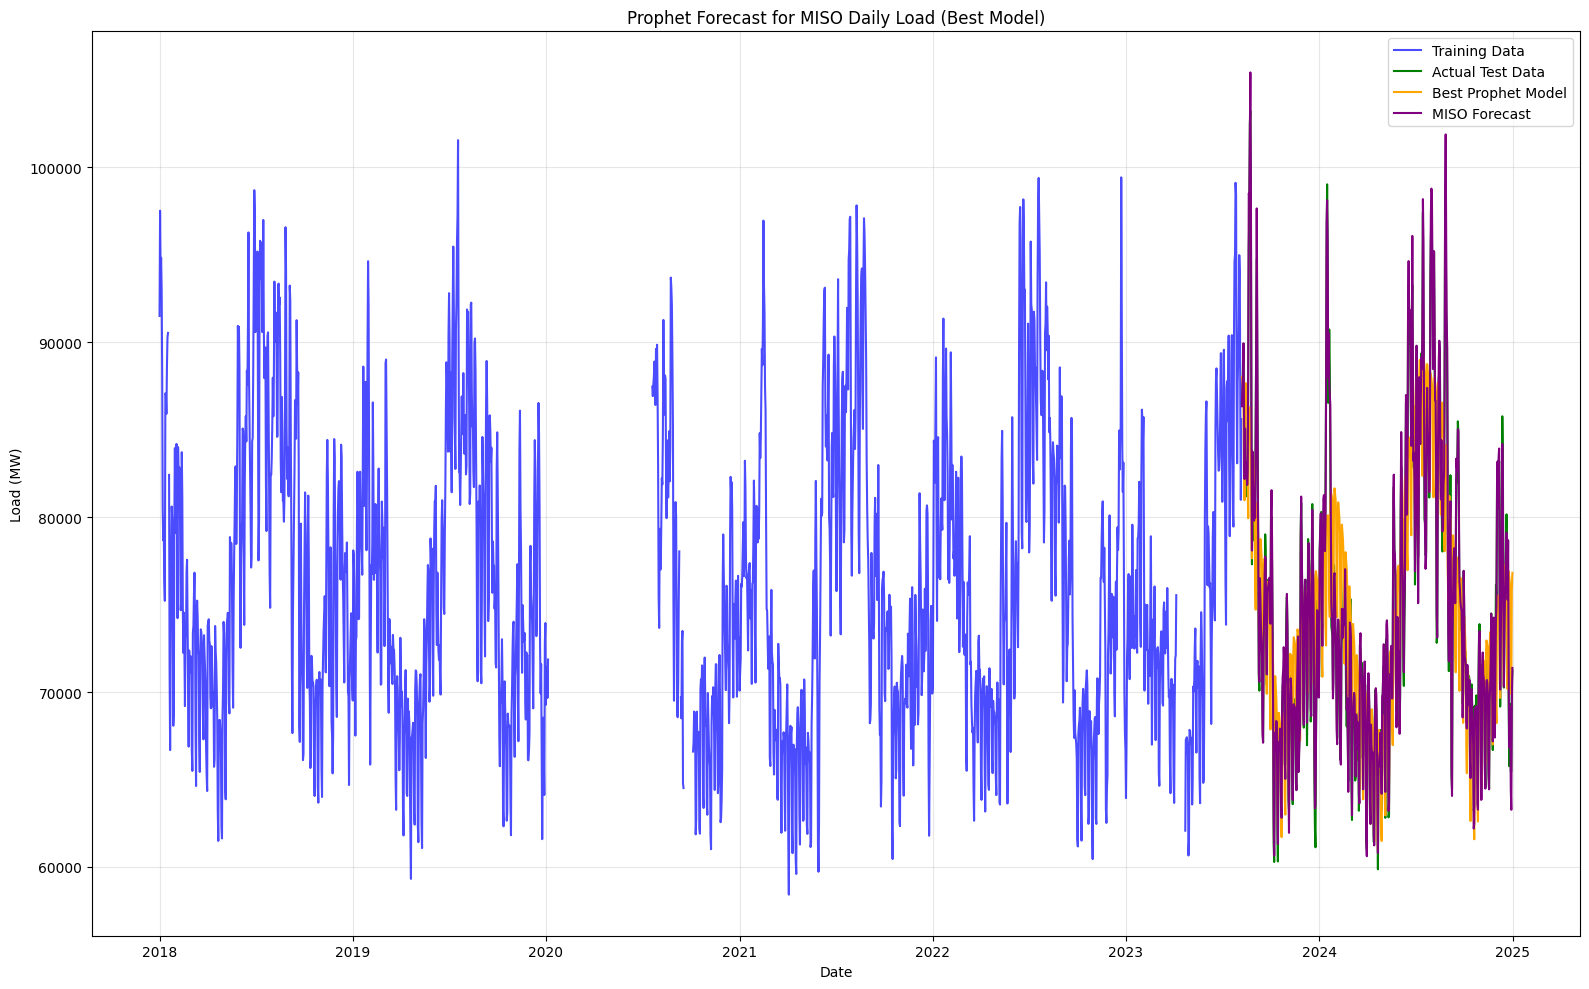

In [ ]:
# Plot results with best model
plt.figure(figsize=(16, 10))
plt.plot(train_prophet['ds'], train_prophet['y'], label='Training Data', color='blue', alpha=0.7)
plt.plot(test_prophet['ds'], test_prophet['y'], label='Actual Test Data', color='green')
plt.plot(test_prophet['ds'], best_prophet_forecast, label='Best Prophet Model', color='orange')
plt.plot(test_prophet['ds'], miso_forecast_test.values, label='MISO Forecast', color='purple')
plt.xlabel('Date')
plt.ylabel('Load (MW)')
plt.title('Prophet Forecast for MISO Daily Load (Best Model)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

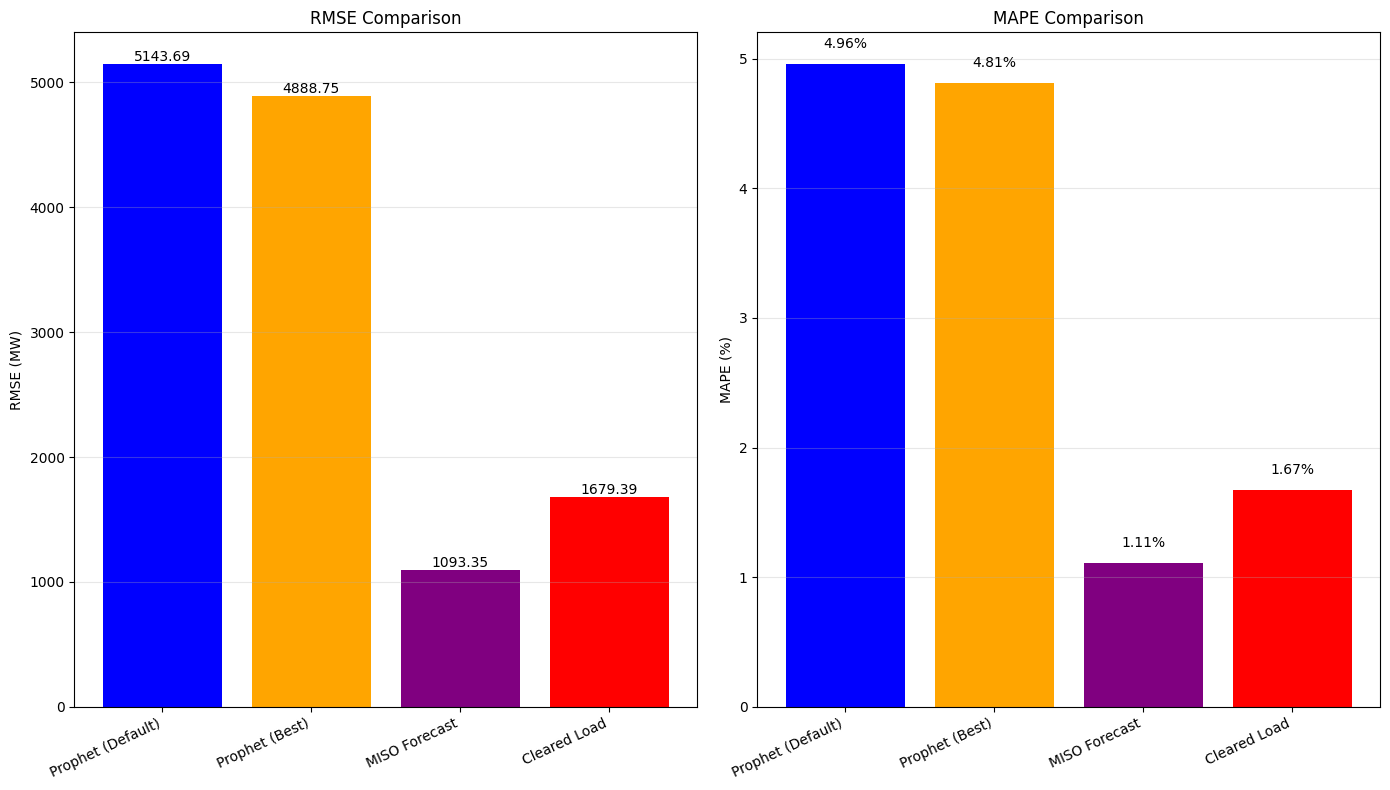

In [ ]:
# Updated model comparison
model_names = ['Prophet (Default)', 'Prophet (Best)', 'MISO Forecast', 'Cleared Load']
rmse_values = [prophet_rmse, best_prophet_rmse, miso_forecast_rmse, cleared_rmse]
mape_values = [prophet_mape, best_prophet_mape, miso_forecast_mape, cleared_mape]

plt.figure(figsize=(14, 8))

plt.subplot(121)
bars = plt.bar(model_names, rmse_values, color=['blue', 'orange', 'purple', 'red'])
plt.title('RMSE Comparison')
plt.ylabel('RMSE (MW)')
plt.grid(True, axis='y', alpha=0.3)
plt.xticks(rotation=25, ha='right')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{height:.2f}', ha='center', va='bottom')

plt.subplot(122)
bars = plt.bar(model_names, mape_values, color=['blue', 'orange', 'purple', 'red'])
plt.title('MAPE Comparison')
plt.ylabel('MAPE (%)')
plt.grid(True, axis='y', alpha=0.3)
plt.xticks(rotation=25, ha='right')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{height:.2f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Seasonality Trends

In [ ]:
# Seasonal decomposition to understand patterns
from statsmodels.tsa.seasonal import seasonal_decompose

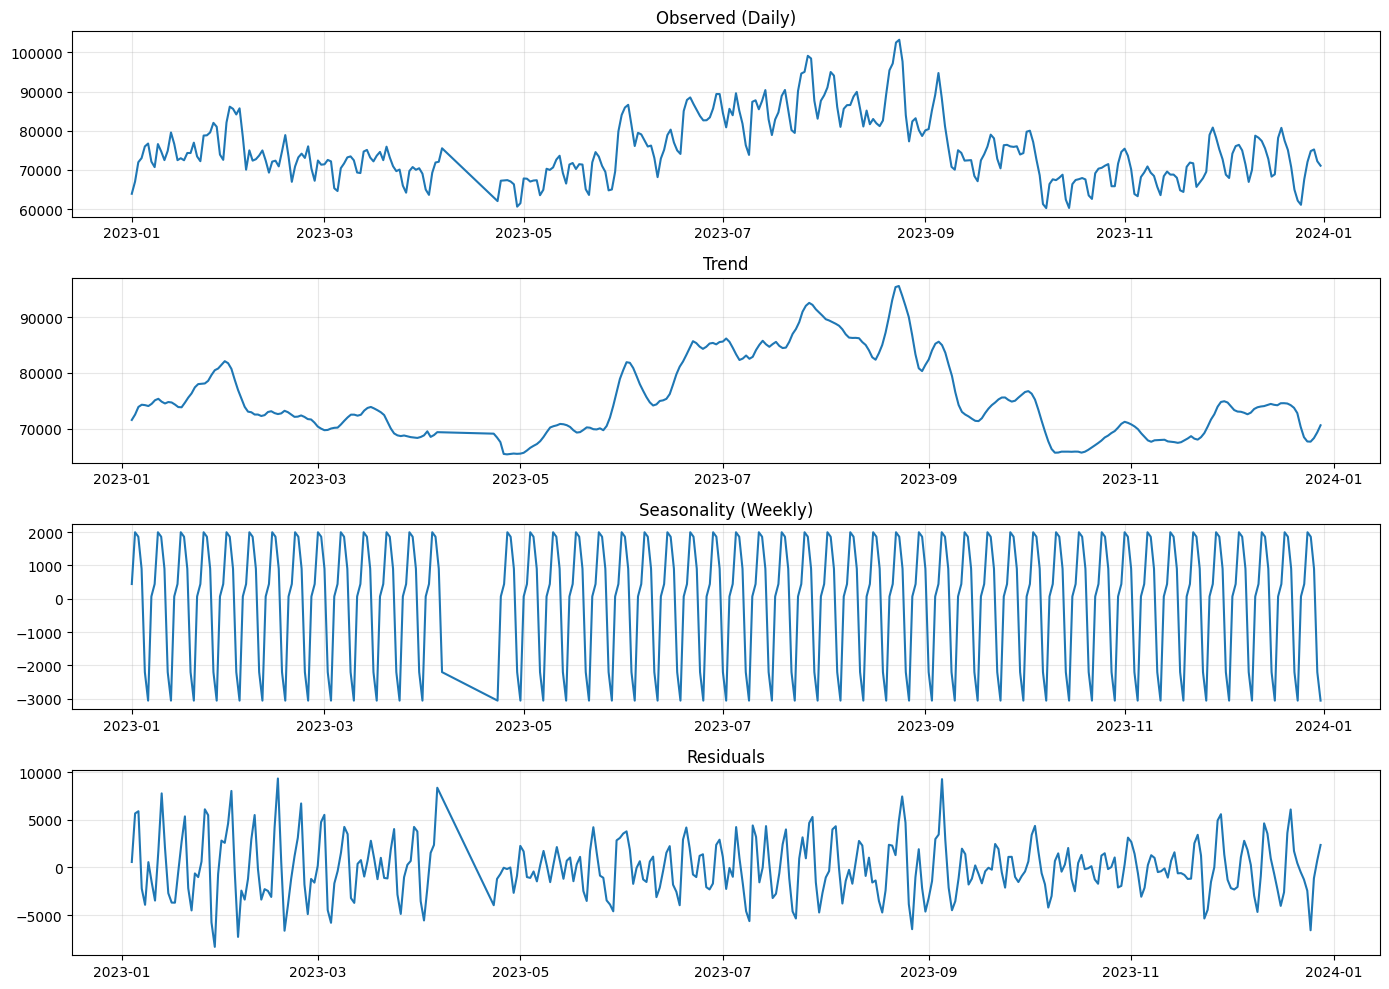

In [ ]:
# Use daily data for a year to observe weekly patterns
sample_year = daily_actual['2023-01-01':'2023-12-31']
sample_year = sample_year.dropna()  # Remove any NaN values

# If sample has data, perform seasonal decomposition
if len(sample_year) > 0:
    # Make sure we have enough data points for the period (at least 2*period points)
    if len(sample_year) >= 14:  # At least 2 weeks for weekly seasonality
        seasonal_result_weekly = seasonal_decompose(sample_year, model='additive', period=7)  # 7 days for weekly seasonality

        plt.figure(figsize=(14, 10))
        plt.subplot(411)
        plt.plot(seasonal_result_weekly.observed)
        plt.title('Observed (Daily)')
        plt.grid(True, alpha=0.3)

        plt.subplot(412)
        plt.plot(seasonal_result_weekly.trend)
        plt.title('Trend')
        plt.grid(True, alpha=0.3)

        plt.subplot(413)
        plt.plot(seasonal_result_weekly.seasonal)
        plt.title('Seasonality (Weekly)')
        plt.grid(True, alpha=0.3)

        plt.subplot(414)
        plt.plot(seasonal_result_weekly.resid)
        plt.title('Residuals')
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()
    else:
        print("Not enough data points for weekly seasonal decomposition (need at least 14 days)")
else:
    print("No valid data found in the selected date range for seasonal decomposition")

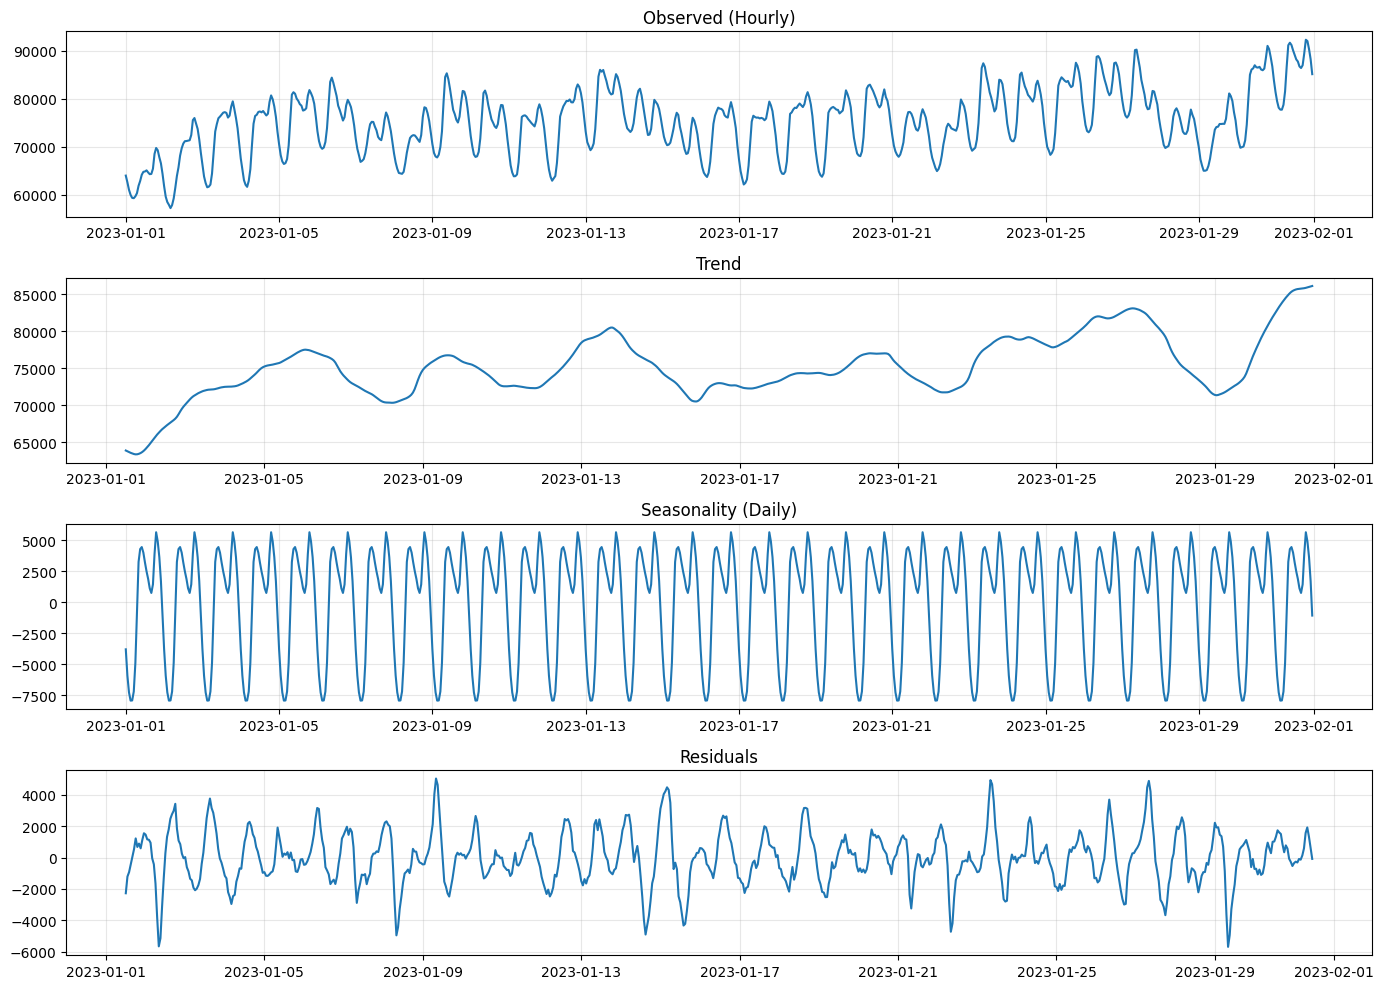

In [ ]:
# Use hourly data for a month to observe daily patterns - with similar fix for missing values
hourly_sample = df['ActualLoad']['2023-01-01':'2023-01-31']
hourly_sample = hourly_sample.dropna()  # Remove any NaN values

if len(hourly_sample) > 0:
    # Make sure we have enough data points for daily seasonality (at least 2*24 hours)
    if len(hourly_sample) >= 48:
        seasonal_result_daily = seasonal_decompose(hourly_sample, model='additive', period=24)  # 24 hours for daily seasonality

        plt.figure(figsize=(14, 10))
        plt.subplot(411)
        plt.plot(seasonal_result_daily.observed)
        plt.title('Observed (Hourly)')
        plt.grid(True, alpha=0.3)

        plt.subplot(412)
        plt.plot(seasonal_result_daily.trend)
        plt.title('Trend')
        plt.grid(True, alpha=0.3)

        plt.subplot(413)
        plt.plot(seasonal_result_daily.seasonal)
        plt.title('Seasonality (Daily)')
        plt.grid(True, alpha=0.3)

        plt.subplot(414)
        plt.plot(seasonal_result_daily.resid)
        plt.title('Residuals')
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()
    else:
        print("Not enough data points for daily seasonal decomposition (need at least 48 hours)")
else:
    print("No valid data found in the selected hourly date range for seasonal decomposition")

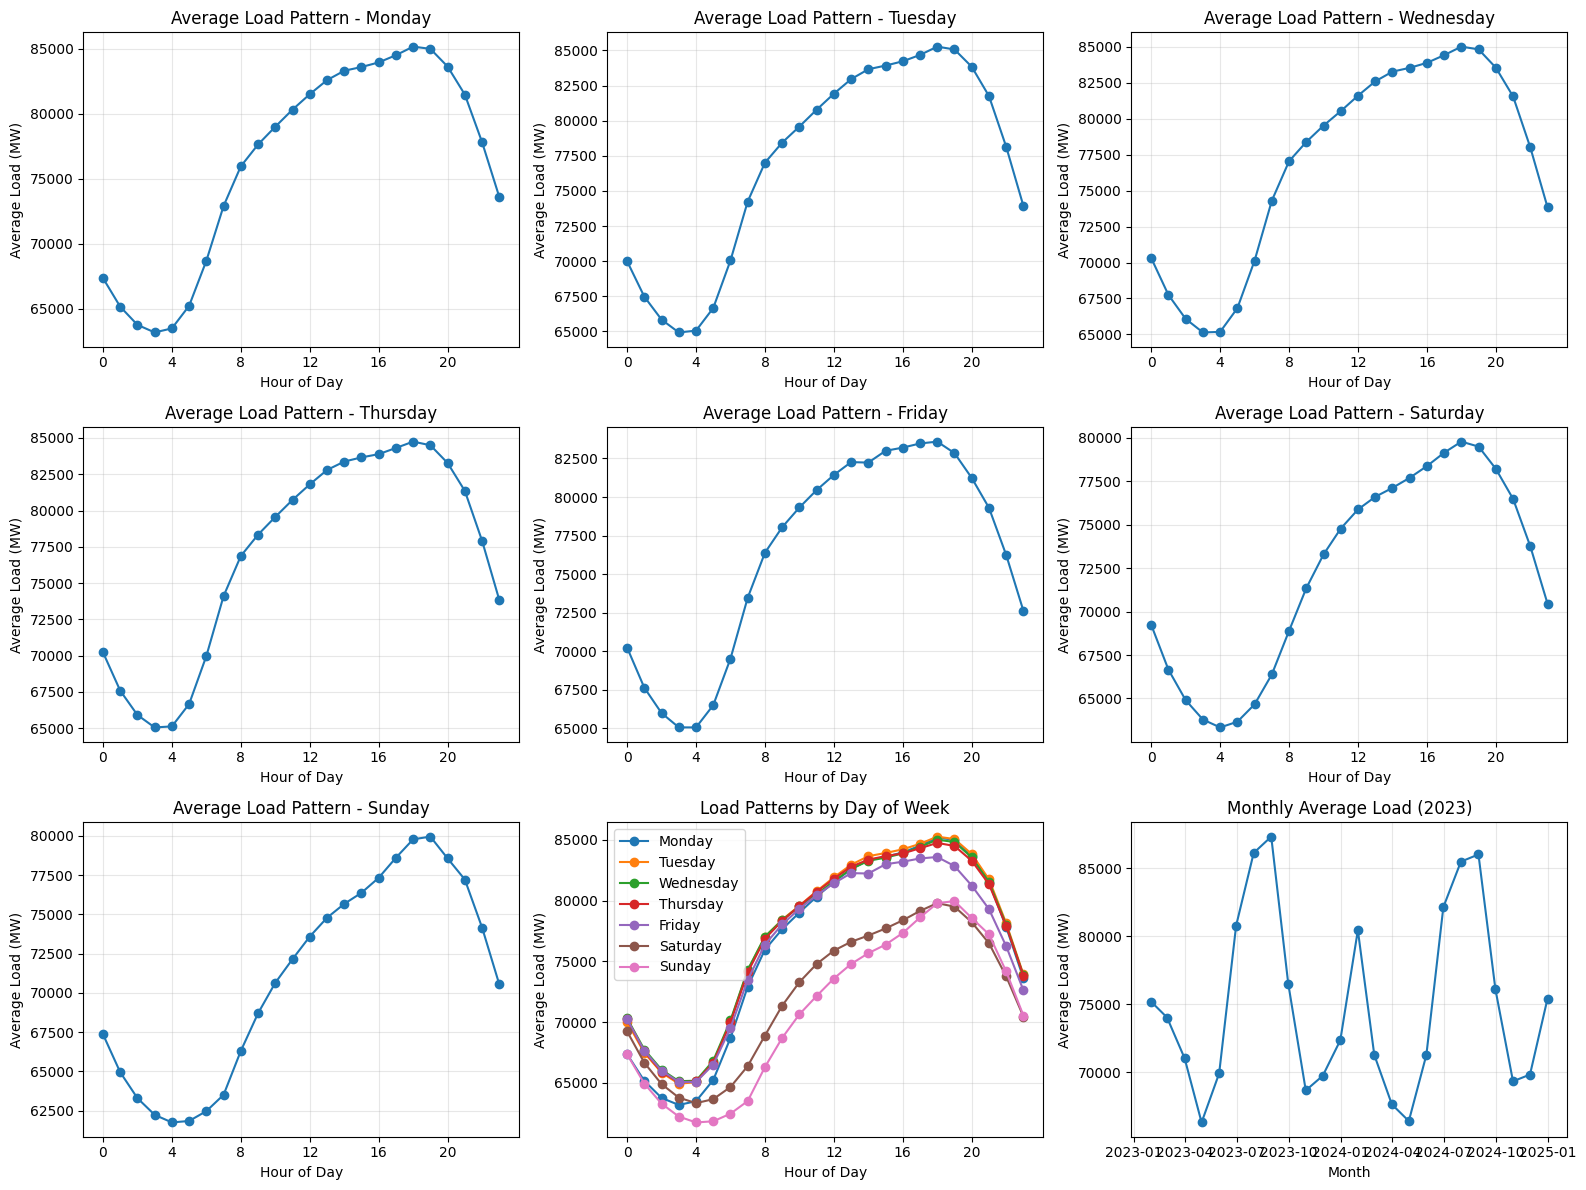

In [ ]:
# Plot hourly patterns by day of week
df['DayOfWeek'] = df.index.dayofweek  # 0 = Monday, 6 = Sunday
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Sample recent data (last year)
recent_data = df.loc['2023-01-01':]

plt.figure(figsize=(16, 12))
for i, day in enumerate(range(7)):
    day_data = recent_data[recent_data['DayOfWeek'] == day]
    hourly_avg = day_data.groupby('Hour')['ActualLoad'].mean()

    plt.subplot(3, 3, i+1)
    plt.plot(hourly_avg.index, hourly_avg.values, 'o-')
    plt.title(f'Average Load Pattern - {day_names[day]}')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Load (MW)')
    plt.xticks(range(0, 24, 4))
    plt.grid(True, alpha=0.3)

# Add a subplot for all days comparison
plt.subplot(3, 3, 8)
for day in range(7):
    day_data = recent_data[recent_data['DayOfWeek'] == day]
    hourly_avg = day_data.groupby('Hour')['ActualLoad'].mean()
    plt.plot(hourly_avg.index, hourly_avg.values, 'o-', label=day_names[day])
plt.title('Load Patterns by Day of Week')
plt.xlabel('Hour of Day')
plt.ylabel('Average Load (MW)')
plt.xticks(range(0, 24, 4))
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

# Add seasonal pattern subplot
plt.subplot(3, 3, 9)
monthly_avg = recent_data.resample('M')['ActualLoad'].mean()
plt.plot(monthly_avg.index, monthly_avg.values, 'o-')
plt.title('Monthly Average Load (2023)')
plt.xlabel('Month')
plt.ylabel('Average Load (MW)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# Compare forecast accuracy across different times of day
hourly_subset = df.iloc[-8760*2:]  # Last 2 years for hourly analysis
hourly_subset = hourly_subset.dropna(subset=['ActualLoad', 'ForecastedLoad'])

# Create a forecast error by hour analysis
hourly_error_analysis = hourly_subset.groupby('Hour')[['ForecastError', 'ForecastErrorPercent']].agg(
    ['mean', 'std', 'min', 'max', lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)]
)
hourly_error_analysis.columns = ['_'.join(col).strip() for col in hourly_error_analysis.columns.values]

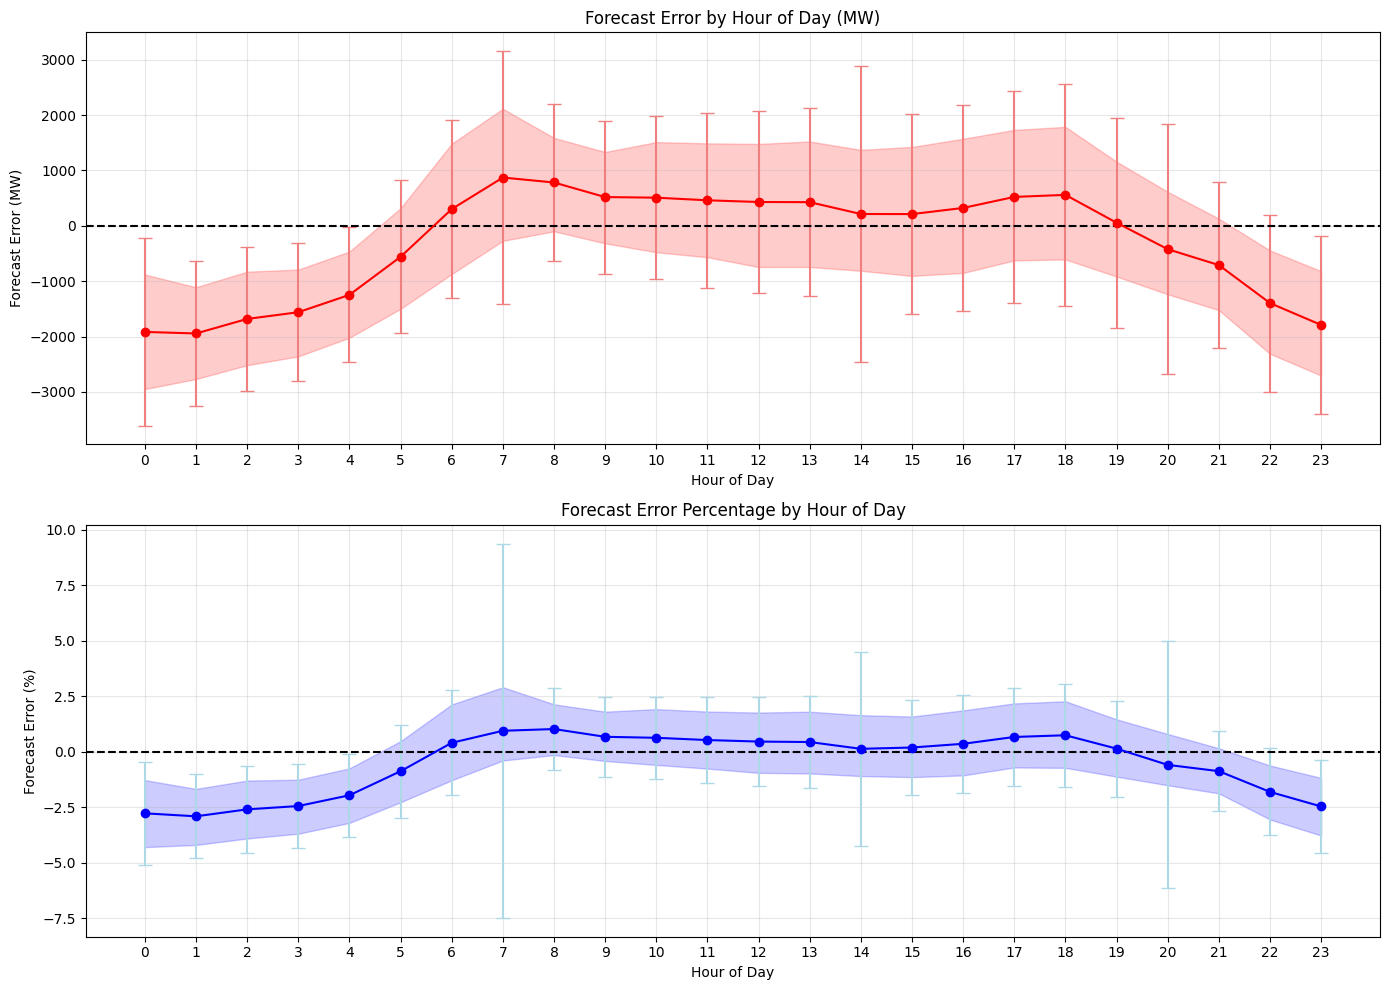

In [ ]:
# Plot the hourly error patterns
plt.figure(figsize=(14, 10))

plt.subplot(211)
plt.errorbar(
    hourly_error_analysis.index,
    hourly_error_analysis['ForecastError_mean'],
    yerr=hourly_error_analysis['ForecastError_std'],
    fmt='o-', capsize=5, color='red', ecolor='lightcoral'
)
plt.fill_between(
    hourly_error_analysis.index,
    hourly_error_analysis['ForecastError_<lambda_0>'],  # 25th percentile
    hourly_error_analysis['ForecastError_<lambda_1>'],  # 75th percentile
    color='red', alpha=0.2
)
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Forecast Error by Hour of Day (MW)')
plt.xlabel('Hour of Day')
plt.ylabel('Forecast Error (MW)')
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3)

plt.subplot(212)
plt.errorbar(
    hourly_error_analysis.index,
    hourly_error_analysis['ForecastErrorPercent_mean'],
    yerr=hourly_error_analysis['ForecastErrorPercent_std'],
    fmt='o-', capsize=5, color='blue', ecolor='lightblue'
)
plt.fill_between(
    hourly_error_analysis.index,
    hourly_error_analysis['ForecastErrorPercent_<lambda_0>'],  # 25th percentile
    hourly_error_analysis['ForecastErrorPercent_<lambda_1>'],  # 75th percentile
    color='blue', alpha=0.2
)
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Forecast Error Percentage by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Forecast Error (%)')
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary of Findings

In [ ]:
# Create a summary of findings
print("\n=== SUMMARY OF FINDINGS ===")
print(f"1. Default Prophet model RMSE: {prophet_rmse:.2f} MW, MAPE: {prophet_mape:.2f}%")
print(f"2. Best Prophet model RMSE: {best_prophet_rmse:.2f} MW, MAPE: {best_prophet_mape:.2f}%")
print(f"3. MISO Forecast RMSE: {miso_forecast_rmse:.2f} MW, MAPE: {miso_forecast_mape:.2f}%")
print(f"4. Cleared Load RMSE: {cleared_rmse:.2f} MW, MAPE: {cleared_mape:.2f}%")

print("\nForecast Error Analysis:")
print(f"- Mean Forecast Error: {df['ForecastError'].mean():.2f} MW ({df['ForecastErrorPercent'].mean():.2f}%)")
print(f"- Hours with highest forecast error: {hourly_error_analysis['ForecastError_mean'].abs().nlargest(3).index.tolist()}")
print(f"- Hours with highest forecast error %: {hourly_error_analysis['ForecastErrorPercent_mean'].abs().nlargest(3).index.tolist()}")

# Check if our best ARIMA model outperforms MISO forecasts
if best_prophet_rmse < miso_forecast_rmse:
    improvement = (miso_forecast_rmse - best_prophet_rmse) / miso_forecast_rmse * 100
    print(f"\nThe best ARIMA model outperforms MISO forecasts by {improvement:.2f}%")
else:
    difference = (best_prophet_rmse - miso_forecast_rmse) / miso_forecast_rmse * 100
    print(f"\nMISO forecasts outperform the best ARIMA model by {difference:.2f}%")


=== SUMMARY OF FINDINGS ===
1. Default Prophet model RMSE: 5143.69 MW, MAPE: 4.96%
2. Best Prophet model RMSE: 4888.75 MW, MAPE: 4.81%
3. MISO Forecast RMSE: 1093.35 MW, MAPE: 1.11%
4. Cleared Load RMSE: 1679.39 MW, MAPE: 1.67%

Forecast Error Analysis:
- Mean Forecast Error: -157.34 MW (-0.28%)
- Hours with highest forecast error: [1, 0, 23]
- Hours with highest forecast error %: [1, 0, 2]

MISO forecasts outperform the best ARIMA model by 347.14%


**